In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

%matplotlib inline

## Spotify API

In [ ]:
client_id='7438769d2e044325a9871eae4000971a'
client_secret='e2b81e7957ae44a0862feb6e163d22fc'
redirect_uri='http://localhost:3000'

Since spotify API limits the number of tracks returned in a single query to 50 song track IDs, I will utilize a nested loop to retrieve all songs I've liked (1,094 songs) and append it to the same list

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

#Spotify API credentials
client_id='95220ed99e0d442eb4a05563cc60d01f'
client_secret='c8489086c20148d580b51e7cb7298d87'  
redirect_uri = 'http://localhost:3000'       

# Setting up the Spotify OAuth handler
scope = 'user-library-read'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                               scope=scope))


# create empty lists to store results
artist_name = []
track_name = []
popularity = []
track_id = []

for offset in range(0,1100,50):
    track_results = sp.current_user_saved_tracks(limit=50, offset=offset)
    for item in track_results['items']:
        track = item['track']
        artist_name.append(track['artists'][0]['name'])
        track_name.append(track['name'])
        track_id.append(track['id'])
        popularity.append(track['popularity'])

In [ ]:
len(track_id)

In [ ]:
import pandas as pd

df_tracks = pd.DataFrame({
    'artist_name': artist_name,
    'track_name': track_name,
    'popularity': popularity,
    'track_id': track_id
})

print(df_tracks.shape)
df_tracks.head()

Next, checking for duplicate songs. The same song can have different track_id's depending on whether it was a single release, part of album, etc

In [ ]:
df_tracks[df_tracks.duplicated(subset=['artist_name','track_name'], keep=False)].count()

In [ ]:
df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace = True)

check to see if duplicates were dropped

In [ ]:
df_tracks[df_tracks.duplicated(subset=['artist_name','track_name'],keep=False)].count()

I also want the artist genre as this likely will be the biggest determinant of whether I will like a song or not. Some tracks may not have a genre, so I will check for this and assign the value of "unknown genre" if empty.

In [ ]:
client_id='95220ed99e0d442eb4a05563cc60d01f'
client_secret='c8489086c20148d580b51e7cb7298d87'    
redirect_uri = 'http://localhost:3000'       

scope = 'user-library-read'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                               scope=scope))

track_ids = df_tracks['track_id'].tolist()

artist_ids = []
artist_genres = []

for track_id in track_ids:
    track_info = sp.track(track_id)
    artist_id = track_info['artists'][0]['id']
    artist_ids.append(artist_id)

    artist_info = sp.artist(artist_id)
    genres = artist_info['genres']
    artist_genres.append(genres)

df_tracks['artist_id'] = artist_ids
df_tracks['artist_genre'] = artist_genres

I noticed that some tracks have no genre, and just empty brackets []. I will replace these with "unknown genre". 

In [25]:
#check for empty lists in the 'artist_genre' column
has_empty_lists = df['artist_genre'].apply(lambda x: isinstance(x, list) and len(x) == 0).any()
has_empty_lists

False

In [ ]:
def replace_empty_genre_list(genre):
    # Check if the genre is an empty list
    if isinstance(genre, list) and len(genre) == 0:
        return 'Unknown Genre'
    else:
        return genre

# Apply the function
df_tracks['artist_genre'] = df_tracks['artist_genre'].apply(replace_empty_genre_list)

# Verify
df_tracks[df_tracks['artist_genre'] == "Unknown Genre"].head()


Now we can retrive the audio features using the track ids

In [ ]:
client_id='95220ed99e0d442eb4a05563cc60d01f'
client_secret='c8489086c20148d580b51e7cb7298d87'    
redirect_uri = 'http://localhost:3000'       


scope = 'user-library-read'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                               scope=scope))



all_audio_features = []

        
for i in range(0,len(df_tracks['track_id']),100):
    batch = df_tracks['track_id'][i:i+100]
    audio_features = sp.audio_features(batch)
    all_audio_features.extend(audio_features)
        

In [ ]:
df_audio_features = pd.DataFrame(all_audio_features)
df_audio_features.head()

Drop unecessary columns and change id to track_id to match first dataframe

In [ ]:
columns_to_drop = ['type', 'uri', 'track_href', 'analysis_url']

df_audio_features.drop(columns_to_drop, axis=1,inplace=True)

df_audio_features.rename(columns={'id': 'track_id'}, inplace=True)

df_audio_features.shape

In [ ]:
# Merge dataframes
df = pd.merge(df_tracks, df_audio_features, on='track_id',how='inner')

In [ ]:
df.to_csv('/Users/lindaseong/Desktop/Data_Science_Portfolio_work_2023/Project3_Spotify/spotify_liked_songs_metadata_audio_features_genres.csv')

Now I'm going to repeat the spotify scraping and data processing for my disliked songs playlist!
The only difference here is that i need to obtain the spotify ID of my disliked playlist using the url link and then pull the songs from that specific ID. For playlists, we can pull 100 songs at a time. I will also include a check to avoid errors for missing or invalid track data. For some reason, I had to modify the code to directly assign danceability and other audio features, in order to avoid NaN for danceability on all tracks.

In [ ]:
client_id = '95220ed99e0d442eb4a05563cc60d01f' 
client_secret = 'c8489086c20148d580b51e7cb7298d87'    
redirect_uri = 'http://localhost:3000'
playlist_id = '6nPX2DGoVNJvO9CIjhdBDu'


sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                               scope="playlist-read-private"))


artist_name = []
track_name = []
popularity = []
track_id = []
artist_id = []

for offset in range(0,950,100):
    track_results = sp.playlist_tracks(playlist_id, limit=100, offset=offset)
    for item in track_results['items']:
        track = item['track']
        artist_name.append(track['artists'][0]['name'])
        track_name.append(track['name'])
        track_id.append(track['id'])
        popularity.append(track['popularity'])
        artist_id.append(track['artists'][0]['id'])

dislikes_df_tracks = pd.DataFrame({
    'artist_name': artist_name,
    'track_name': track_name,
    'track_id': track_id,
    'popularity': popularity,
    'artist_id': artist_id,
    
})

print(dislikes_df_tracks.shape)
dislikes_df_tracks

In [ ]:
dislikes_df_tracks[dislikes_df_tracks.duplicated(subset=['artist_name','track_name'], keep=False)].count()

In [ ]:
dislikes_df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace = True)

In [ ]:
dislikes_df_tracks[dislikes_df_tracks.duplicated(subset=['artist_name','track_name'],keep=False)].count()

In [ ]:
client_id = '95220ed99e0d442eb4a05563cc60d01f' 
client_secret = 'c8489086c20148d580b51e7cb7298d87'    
redirect_uri = 'http://localhost:3000'       
playlist_id = '6nPX2DGoVNJvO9CIjhdBDu'


sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                               scope="playlist-read-private"))

artist_ids = dislikes_df_tracks['artist_id'].tolist()

artist_genres = []

for artist_id in artist_ids:
    artist_info = sp.artist(artist_id)
    genres = artist_info.get('genres')
    artist_genres.append(genres)

dislikes_df_tracks['artist_genre'] = artist_genres

In [ ]:
dislikes_df_tracks

In [ ]:
dislikes_df_tracks['artist_genre'] = dislikes_df_tracks['artist_genre'].apply(replace_empty_genre_list)

# Verify
dislikes_df_tracks[dislikes_df_tracks['artist_genre'] == "Unknown Genre"].head()


In [ ]:
dislike_audio_features = []

for i in range(0,len(dislikes_df_tracks['track_id']),100):
    batch = dislikes_df_tracks['track_id'][i:i+100]
    audio_features = sp.audio_features(batch)
    dislike_audio_features.extend(audio_features)

dislikes_audio_features_df = pd.DataFrame(dislike_audio_features)
dislikes_playlist_df = pd.concat([dislikes_df_tracks, dislikes_audio_features_df], axis=1)
dislikes_playlist_df.head()

In [ ]:
dislikes_playlist_df = pd.concat([dislikes_df_tracks, dislikes_audio_features_df], axis=1)

In [ ]:
#check for empty lists in the 'artist_genre' column
has_empty_lists = dislikes_playlist_df['artist_genre'].apply(lambda x: isinstance(x, list) and len(x) == 0).any()
has_empty_lists

In [ ]:
# Apply the replace function 
dislikes_playlist_df['artist_genre'] = dislikes_playlist_df['artist_genre'].apply(replace_empty_genre_list)

# Verify if the replacement worked
dislikes_playlist_df[dislikes_playlist_df['artist_genre'] == "unknown genre"].head()

In [ ]:
columns_to_drop = ['type', 'uri', 'id', 'track_href', 'analysis_url']

dislikes_playlist_df.drop(columns_to_drop, axis=1,inplace=True)

dislikes_playlist_df.shape

In [ ]:
dislikes_playlist_df.to_csv("/Users/lindaseong/Desktop/Data_Science_Portfolio_work_2023/Project3_Spotify/disliked_songs_metadata_genre_and_audio_features1.csv")

Lastly, I'm going to download 10 songs from Today's Top hits to test the model. 

In [193]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

client_id = '95220ed99e0d442eb4a05563cc60d01f' 
client_secret = 'c8489086c20148d580b51e7cb7298d87'    
redirect_uri = 'http://localhost:3000'
playlist_id = '37i9dQZF1DXcBWIGoYBM5M'


sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri))


artist_name = []
track_name = []
popularity = []
track_id = []
artist_id = []


track_results = sp.playlist_tracks(playlist_id)
for item in track_results['items']:
    track = item['track']
    artist_name.append(track['artists'][0]['name'])
    track_name.append(track['name'])
    track_id.append(track['id'])
    popularity.append(track['popularity'])
    artist_id.append(track['artists'][0]['id'])

test_tracks = pd.DataFrame({
    'artist_name': artist_name,
    'track_name': track_name,
    'track_id': track_id,
    'popularity': popularity,
    'artist_id': artist_id,
    
})

print(test_tracks.shape)
test_tracks

(50, 5)


,artist_name,track_name,track_id,popularity,artist_id
0,Noah Kahan,Stick Season,0mflMxspEfB0VbI1kyLiAv,95,2RQXRUsr4IW1f3mKyKsy4B
1,SZA,Snooze,4iZ4pt7kvcaH6Yo8UoZ4s2,93,7tYKF4w9nC0nq9CsPZTHyP
2,Jack Harlow,Lovin On Me,4xhsWYTOGcal8zt0J161CU,98,2LIk90788K0zvyj2JJVwkJ
3,Tate McRae,greedy,3rUGC1vUpkDG9CZFHMur1t,99,45dkTj5sMRSjrmBSBeiHym
4,Doja Cat,Paint The Town Red,2IGMVunIBsBLtEQyoI1Mu7,94,5cj0lLjcoR7YOSnhnX0Po5
5,Tyla,Water,5aIVCx5tnk0ntmdiinnYvw,95,3SozjO3Lat463tQICI9LcE
6,Taylor Swift,Cruel Summer,1BxfuPKGuaTgP7aM0Bbdwr,99,06HL4z0CvFAxyc27GXpf02
7,Olivia Rodrigo,vampire,1kuGVB7EU95pJObxwvfwKS,95,1McMsnEElThX1knmY4oliG
8,Billie Eilish,What Was I Made For? [From The Motion Picture ...,6wf7Yu7cxBSPrRlWeSeK0Q,94,6qqNVTkY8uBg9cP3Jd7DAH
9,Kenya Grace,Strangers,5mjYQaktjmjcMKcUIcqz4s,96,7uMDnSZyUYNBPLhPMNuaM2


In [197]:
test_audio_features = []
track_ids= test_tracks['track_id']

for track_id in track_ids:
    audio_features = sp.audio_features(track_id)
    test_audio_features.extend(audio_features)

test_audio_features_df = pd.DataFrame(test_audio_features)
test_playlist_df = pd.concat([test_tracks, test_audio_features_df], axis=1)
test_playlist_df.head()

,artist_name,track_name,track_id,popularity,artist_id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Noah Kahan,Stick Season,0mflMxspEfB0VbI1kyLiAv,95,2RQXRUsr4IW1f3mKyKsy4B,0.662,0.488,9,-6.894,1,...,0.1020,0.817,117.913,audio_features,0mflMxspEfB0VbI1kyLiAv,spotify:track:0mflMxspEfB0VbI1kyLiAv,https://api.spotify.com/v1/tracks/0mflMxspEfB0...,https://api.spotify.com/v1/audio-analysis/0mfl...,182347,4
1,SZA,Snooze,4iZ4pt7kvcaH6Yo8UoZ4s2,93,7tYKF4w9nC0nq9CsPZTHyP,0.559,0.551,5,-7.231,1,...,0.1100,0.392,143.008,audio_features,4iZ4pt7kvcaH6Yo8UoZ4s2,spotify:track:4iZ4pt7kvcaH6Yo8UoZ4s2,https://api.spotify.com/v1/tracks/4iZ4pt7kvcaH...,https://api.spotify.com/v1/audio-analysis/4iZ4...,201800,4
2,Jack Harlow,Lovin On Me,4xhsWYTOGcal8zt0J161CU,98,2LIk90788K0zvyj2JJVwkJ,0.943,0.558,2,-4.911,1,...,0.0937,0.606,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
3,Tate McRae,greedy,3rUGC1vUpkDG9CZFHMur1t,99,45dkTj5sMRSjrmBSBeiHym,0.750,0.733,6,-3.180,0,...,0.1140,0.844,111.018,audio_features,3rUGC1vUpkDG9CZFHMur1t,spotify:track:3rUGC1vUpkDG9CZFHMur1t,https://api.spotify.com/v1/tracks/3rUGC1vUpkDG...,https://api.spotify.com/v1/audio-analysis/3rUG...,131872,1
4,Doja Cat,Paint The Town Red,2IGMVunIBsBLtEQyoI1Mu7,94,5cj0lLjcoR7YOSnhnX0Po5,0.868,0.538,5,-8.603,1,...,0.0901,0.732,99.968,audio_features,2IGMVunIBsBLtEQyoI1Mu7,spotify:track:2IGMVunIBsBLtEQyoI1Mu7,https://api.spotify.com/v1/tracks/2IGMVunIBsBL...,https://api.spotify.com/v1/audio-analysis/2IGM...,231750,4


I'm going to pick 5 songs I like and 5 songs I dislike to evaluate my model and save that as the final test list.

In [198]:
test_playlist_df.to_csv("/Users/lindaseong/Desktop/Data_Science_Portfolio_work_2023/Project3_Spotify/test_tracks_and_audio_features_todays_top_hits.csv")

## Data Processing

Reloading datasets since pulling the track data takes a while and is a good stopping point

In [22]:
df = pd.read_csv('/Users/lindaseong/Desktop/Data_Science_Portfolio_work_2023/Project3_Spotify/spotify_liked_songs_metadata_audio_features_genres.csv', index_col =0)

In [23]:
df

,artist_name,track_name,popularity,track_id,artist_id,artist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,IVE,Baddie,81,7uyeEbG6hyApgXuEypGcsZ,6RHTUrRF63xao58xh9FXYJ,['k-pop girl group'],0.736,0.678,5,-4.503,1,0.0464,0.045900,0.000005,0.1040,0.7570,160.045,154360,4
1,Stray Kids,"Sorry, I Love You",63,5kkOHHTccylnkYxDRgDWMs,2dIgFjalVxs4ThymZ67YCE,"['k-pop', 'k-pop boy group', 'pop']",0.743,0.661,1,-5.287,1,0.0736,0.362000,0.000000,0.2040,0.6020,100.039,177613,4
2,Stray Kids,S-Class,81,3gTQwwDNJ42CCLo3Sf4JDd,2dIgFjalVxs4ThymZ67YCE,"['k-pop', 'k-pop boy group', 'pop']",0.886,0.781,5,-1.837,0,0.3330,0.089500,0.000000,0.0715,0.6720,104.996,195689,4
3,Stray Kids,LALALALA,86,1OG1NoKpZZLrMqMYCk9m84,2dIgFjalVxs4ThymZ67YCE,"['k-pop', 'k-pop boy group', 'pop']",0.705,0.849,0,-2.595,1,0.0493,0.064700,0.000000,0.6530,0.6090,125.976,182224,4
4,B.I,Alive,0,4qkK6HzeumxsOr2EugiSYM,0UntV1Bw2hk3fbRrm9eMP6,['k-pop'],0.619,0.835,7,-5.724,1,0.2800,0.381000,0.000257,0.1350,0.4550,176.279,174535,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,Armin van Buuren,Mirage [Mix Cut],2,6GXKmBzrcFkIR2ISacFq0c,0SfsnGyD8FpIN4U4WCkBZ5,"['dutch trance', 'edm', 'pop dance', 'progress...",0.470,0.834,2,-5.774,0,0.0520,0.108000,0.001490,0.4320,0.0740,136.046,183520,4
1052,Armin van Buuren,In And Out Of Love [Mix Cut],2,6XcJ3rcjmuUeIRHqwbDo64,0SfsnGyD8FpIN4U4WCkBZ5,"['dutch trance', 'edm', 'pop dance', 'progress...",0.548,0.919,0,-5.647,1,0.0460,0.054500,0.771000,0.2610,0.0769,135.980,137040,4
1053,Andrew Rayel,Dark Warrior [Mix Cut],4,6bdlvSOK6EiHWbDof9wfuz,1UtBjqMZBAmqIPlDrKu7Tr,"['dutch house', 'edm', 'moldovan pop', 'pop da...",0.569,0.942,6,-6.044,1,0.0822,0.000133,0.845000,0.4170,0.1820,132.525,202773,4
1054,Armin van Buuren,Not Giving Up On Love [Mix Cut],2,76r9JlmWJMvnYwyPB3akMo,0SfsnGyD8FpIN4U4WCkBZ5,"['dutch trance', 'edm', 'pop dance', 'progress...",0.491,0.829,4,-4.848,0,0.0966,0.772000,0.000172,0.7740,0.4510,139.677,41613,4


How many unqiue genres are listed in the artist_genre column? The genres column is a list of several genres an artist is associated with. 

In [26]:
#this code is for when loading from a csv file
# Extracting all genres from the 'artist_genre' column and removing brackets and quotes
all_genres = df['artist_genre'].str.replace('[\[\]\'\"]', '', regex=True).str.split(',').explode()

# Finding unique genres
unique_genres = list(set(all_genres))


len(unique_genres)

320

320 genres is quite a lot to handle, so I will assign the tracks to more broader genres. I will also include an unknown genre for the tracks that were not assigned artist genres. This process will also one-hot encode the data for our recommendation system.

In [27]:
genre_mappings = {
    'rock': 'Rock',
    'pop': 'Pop',
    'hip-hop': 'Hip-Hop/Rap',
    'rap': 'Hip-Hop/Rap',
    'jazz': 'Jazz',
    'classical': 'Classical',
    'r&b': 'R&B/Soul',
    'soul': 'R&B/Soul',
    'blues': 'Blues',
    'country': 'Country',
    'reggae': 'Reggae',
    'folk': 'Folk',
    'latin': 'Latin',
    'metal': 'Metal',
    'indie': 'Indie',
    'punk': 'Punk',
    'funk': 'Funk',
    'gospel': 'Gospel',
    'heavy metal': 'Heavy Metal',
    'k-pop': 'K-pop',
    'house': 'House/Techno',
    'techno': 'House/Techno',
    'trap': 'Trap/Dubstep',
    'dubstep': 'Trap/Dubstep',
    'electronic': 'Electronic/Dance',
    'dance': 'Electronic/Dance'
}

In [28]:
# Modify the map_genres function to handle non-list entries in 'artist_genre' column

def map_genres(row, genre_mappings):
    try:
        # Attempt to convert string representation of list to actual list
        subgenres = eval(row['artist_genre'])
    except:
        # If conversion fails, treat it as an empty list
        subgenres = []
    
    broader_genres = set()
    for subgenre in subgenres:
        for key, value in genre_mappings.items():
            if key in subgenre.lower():
                broader_genres.add(value)
    
    # Add 'Unknown Genre' if no broader genres are found
    if not broader_genres:
        broader_genres.add('Unknown Genre')
    
    return list(broader_genres)

# Reapply the mapping function
df['broader_genres'] = df.apply(lambda row: map_genres(row, genre_mappings), axis=1)

# Update the list of all broader genres (to include 'Unknown Genre')
all_broader_genres = list(set(genre_mappings.values())) + ['Unknown Genre']

# Reinitialize columns for each broader genre with 0
for genre in all_broader_genres:
    df[genre] = 0

# Reset 1 for the presence of each broader genre
for index, row in df.iterrows():
    for genre in row['broader_genres']:
        df.at[index, genre] = 1

# Display the updated dataframe
df

,artist_name,track_name,popularity,track_id,artist_id,artist_genre,danceability,energy,key,loudness,...,House/Techno,Funk,Jazz,Blues,Country,K-pop,Reggae,Electronic/Dance,Classical,Unknown Genre
0,IVE,Baddie,81,7uyeEbG6hyApgXuEypGcsZ,6RHTUrRF63xao58xh9FXYJ,['k-pop girl group'],0.736,0.678,5,-4.503,...,0,0,0,0,0,1,0,0,0,0
1,Stray Kids,"Sorry, I Love You",63,5kkOHHTccylnkYxDRgDWMs,2dIgFjalVxs4ThymZ67YCE,"['k-pop', 'k-pop boy group', 'pop']",0.743,0.661,1,-5.287,...,0,0,0,0,0,1,0,0,0,0
2,Stray Kids,S-Class,81,3gTQwwDNJ42CCLo3Sf4JDd,2dIgFjalVxs4ThymZ67YCE,"['k-pop', 'k-pop boy group', 'pop']",0.886,0.781,5,-1.837,...,0,0,0,0,0,1,0,0,0,0
3,Stray Kids,LALALALA,86,1OG1NoKpZZLrMqMYCk9m84,2dIgFjalVxs4ThymZ67YCE,"['k-pop', 'k-pop boy group', 'pop']",0.705,0.849,0,-2.595,...,0,0,0,0,0,1,0,0,0,0
4,B.I,Alive,0,4qkK6HzeumxsOr2EugiSYM,0UntV1Bw2hk3fbRrm9eMP6,['k-pop'],0.619,0.835,7,-5.724,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,Armin van Buuren,Mirage [Mix Cut],2,6GXKmBzrcFkIR2ISacFq0c,0SfsnGyD8FpIN4U4WCkBZ5,"['dutch trance', 'edm', 'pop dance', 'progress...",0.470,0.834,2,-5.774,...,1,0,0,0,0,0,0,1,0,0
1052,Armin van Buuren,In And Out Of Love [Mix Cut],2,6XcJ3rcjmuUeIRHqwbDo64,0SfsnGyD8FpIN4U4WCkBZ5,"['dutch trance', 'edm', 'pop dance', 'progress...",0.548,0.919,0,-5.647,...,1,0,0,0,0,0,0,1,0,0
1053,Andrew Rayel,Dark Warrior [Mix Cut],4,6bdlvSOK6EiHWbDof9wfuz,1UtBjqMZBAmqIPlDrKu7Tr,"['dutch house', 'edm', 'moldovan pop', 'pop da...",0.569,0.942,6,-6.044,...,1,0,0,0,0,0,0,1,0,0
1054,Armin van Buuren,Not Giving Up On Love [Mix Cut],2,76r9JlmWJMvnYwyPB3akMo,0SfsnGyD8FpIN4U4WCkBZ5,"['dutch trance', 'edm', 'pop dance', 'progress...",0.491,0.829,4,-4.848,...,1,0,0,0,0,0,0,1,0,0


In [29]:
# Extracting the broad genre columns into a new dataframe
liked_broader_genres_df = df.iloc[:, -22:]

In [30]:
liked_broader_genres_df['Unknown Genre'].sum()

86

In [21]:
df.to_csv('/Users/lindaseong/Desktop/Data_Science_Portfolio_work_2023/Project3_Spotify/spotify_liked_songs_metadata_audio_features_w_broad_genres.csv')

In [37]:
dislikes_df = pd.read_csv('/Users/lindaseong/Desktop/Data_Science_Portfolio_work_2023/Project3_Spotify/disliked_songs_metadata_genre_and_audio_features.csv', index_col =0)

In [38]:
dislikes_df

,artist_name,track_name,track_id,popularity,artist_id,artist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Rebecca Black,Friday,4fK6E2UywZTJIa5kWnCD6x,0,3Vl9fyKMIdLMswk8ai3mm9,Unknown Genre,0.684,0.889,8,-4.555,0,0.1020,0.030700,0.000003,0.7750,0.582,112.004,210026,4
1,Limp Bizkit,Rollin' (Air Raid Vehicle),3IV4swNduIRunHREK80owz,79,165ZgPlLkK7bf5bDoFc6Sb,"['alternative metal', 'funk metal', 'nu metal'...",0.603,0.933,1,-3.358,1,0.1710,0.005910,0.000000,0.2060,0.709,96.306,213760,4
2,Hones-T,Ass and Titties (feat. Qb5),2bCmpSXIQIVSvjgepbic3I,16,1gjYCdpkRbQf6hQmmGNPsj,Unknown Genre,0.705,0.785,9,-4.200,0,0.4030,0.027700,0.000004,0.1280,0.231,145.925,146387,4
3,Gabby Barrett,Glory Days,7qaMlLPdwNiiU1Uiy1oAdO,72,6Iz3eq2aQGFf7TbGT2iahL,['contemporary country'],0.647,0.776,7,-5.221,1,0.0514,0.006860,0.000000,0.1190,0.268,103.919,162733,4
4,Nate Smith,World on Fire,5ya0TmUQw2wHMkq36rPsnd,79,4NYMUsIcUUsBHbV9DICa5x,"['contemporary country', 'modern country pop']",0.461,0.887,11,-4.871,0,0.0429,0.000219,0.000000,0.1040,0.411,95.964,189987,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,Magnolia Park,Do Or Die,03hgA9bbWk17K66vN7wEzp,54,7B76SsfzG0wWk1WEvGzCmY,['pop punk'],0.653,0.795,6,-3.238,1,0.0679,0.342000,0.000104,0.0728,0.885,86.162,251491,4
925,ILLENIUM,Nothing Ever After,2foma3XC28Wk4Fcthqu7lk,59,45eNHdiiabvmbp4erw26rg,"['edm', 'melodic dubstep', 'pop dance']",0.537,0.964,9,-4.157,1,0.1130,0.000599,0.000011,0.0564,0.712,155.017,206903,4
926,BABYMETAL,BxMxC,4bbIpOYtDP48AdC3lzyqyE,31,630wzNP2OL7fl4Xl0GnMWq,"['idol rock', 'j-metal', 'kawaii metal']",0.490,0.956,5,-4.249,0,0.0675,0.000023,0.000000,0.4550,0.412,110.042,179187,4
927,thrown,grayout,6IZ7Pg6C3vduV2gQsycrYS,60,5eBCPtU2iPbzuMRre9BePt,Unknown Genre,0.411,0.939,1,-4.548,0,0.1190,0.000731,0.000000,0.9530,0.320,175.062,168887,4


In [39]:
#this code is for when loading from a csv file
# Extracting all genres from the 'artist_genre' column and removing brackets and quotes
all_genres = dislikes_df['artist_genre'].str.replace('[\[\]\'\"]', '', regex=True).str.split(',').explode()

# Finding unique genres
unique_genres = list(set(all_genres))


len(unique_genres)

660

In [40]:

# Reapply the mapping function
dislikes_df['broader_genres'] = dislikes_df.apply(lambda row: map_genres(row, genre_mappings), axis=1)

# Update the list of all broader genres (to include 'Unknown Genre')
all_broader_genres = list(set(genre_mappings.values())) + ['Unknown Genre']

# Reinitialize columns for each broader genre with 0
for genre in all_broader_genres:
    dislikes_df[genre] = 0

# Reset 1 for the presence of each broader genre
for index, row in dislikes_df.iterrows():
    for genre in row['broader_genres']:
        dislikes_df.at[index, genre] = 1

# Display the updated dataframe
dislikes_df

,artist_name,track_name,track_id,popularity,artist_id,artist_genre,danceability,energy,key,loudness,...,House/Techno,Funk,Jazz,Blues,Country,K-pop,Reggae,Electronic/Dance,Classical,Unknown Genre
0,Rebecca Black,Friday,4fK6E2UywZTJIa5kWnCD6x,0,3Vl9fyKMIdLMswk8ai3mm9,Unknown Genre,0.684,0.889,8,-4.555,...,0,0,0,0,0,0,0,0,0,1
1,Limp Bizkit,Rollin' (Air Raid Vehicle),3IV4swNduIRunHREK80owz,79,165ZgPlLkK7bf5bDoFc6Sb,"['alternative metal', 'funk metal', 'nu metal'...",0.603,0.933,1,-3.358,...,0,1,0,0,0,0,0,0,0,0
2,Hones-T,Ass and Titties (feat. Qb5),2bCmpSXIQIVSvjgepbic3I,16,1gjYCdpkRbQf6hQmmGNPsj,Unknown Genre,0.705,0.785,9,-4.200,...,0,0,0,0,0,0,0,0,0,1
3,Gabby Barrett,Glory Days,7qaMlLPdwNiiU1Uiy1oAdO,72,6Iz3eq2aQGFf7TbGT2iahL,['contemporary country'],0.647,0.776,7,-5.221,...,0,0,0,0,1,0,0,0,0,0
4,Nate Smith,World on Fire,5ya0TmUQw2wHMkq36rPsnd,79,4NYMUsIcUUsBHbV9DICa5x,"['contemporary country', 'modern country pop']",0.461,0.887,11,-4.871,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,Magnolia Park,Do Or Die,03hgA9bbWk17K66vN7wEzp,54,7B76SsfzG0wWk1WEvGzCmY,['pop punk'],0.653,0.795,6,-3.238,...,0,0,0,0,0,0,0,0,0,0
925,ILLENIUM,Nothing Ever After,2foma3XC28Wk4Fcthqu7lk,59,45eNHdiiabvmbp4erw26rg,"['edm', 'melodic dubstep', 'pop dance']",0.537,0.964,9,-4.157,...,0,0,0,0,0,0,0,1,0,0
926,BABYMETAL,BxMxC,4bbIpOYtDP48AdC3lzyqyE,31,630wzNP2OL7fl4Xl0GnMWq,"['idol rock', 'j-metal', 'kawaii metal']",0.490,0.956,5,-4.249,...,0,0,0,0,0,0,0,0,0,0
927,thrown,grayout,6IZ7Pg6C3vduV2gQsycrYS,60,5eBCPtU2iPbzuMRre9BePt,Unknown Genre,0.411,0.939,1,-4.548,...,0,0,0,0,0,0,0,0,0,1


In [41]:
dislikes_df.to_csv('/Users/lindaseong/Desktop/Data_Science_Portfolio_work_2023/Project3_Spotify/disliked_songs_metadata_and_audio_features_w_broad_genre_categories.csv')

In [43]:
dislikes_broader_genres_df = dislikes_df.iloc[:, -22:]

In [44]:
dislikes_broader_genres_df

,R&B/Soul,Indie,Trap/Dubstep,Gospel,Metal,Hip-Hop/Rap,Latin,Folk,Heavy Metal,Punk,...,House/Techno,Funk,Jazz,Blues,Country,K-pop,Reggae,Electronic/Dance,Classical,Unknown Genre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
925,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
926,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Next i'm going to add a column to denote whether the song is from my likes or dislikes and combine the dataframes for EDA. Liked songs will be 1, dislikes 0.

In [81]:
# Add a 'preference' column to each dataset
df['preference'] = 1
dislikes_df['preference'] = 0

all_songs_df = pd.concat([df, dislikes_df], ignore_index=True)

all_songs_df

,artist_name,track_name,popularity,track_id,artist_id,artist_genre,danceability,energy,key,loudness,...,Funk,Jazz,Blues,Country,K-pop,Reggae,Electronic/Dance,Classical,Unknown Genre,preference
0,IVE,Baddie,81,7uyeEbG6hyApgXuEypGcsZ,6RHTUrRF63xao58xh9FXYJ,['k-pop girl group'],0.736,0.678,5,-4.503,...,0,0,0,0,1,0,0,0,0,1
1,Stray Kids,"Sorry, I Love You",63,5kkOHHTccylnkYxDRgDWMs,2dIgFjalVxs4ThymZ67YCE,"['k-pop', 'k-pop boy group', 'pop']",0.743,0.661,1,-5.287,...,0,0,0,0,1,0,0,0,0,1
2,Stray Kids,S-Class,81,3gTQwwDNJ42CCLo3Sf4JDd,2dIgFjalVxs4ThymZ67YCE,"['k-pop', 'k-pop boy group', 'pop']",0.886,0.781,5,-1.837,...,0,0,0,0,1,0,0,0,0,1
3,Stray Kids,LALALALA,86,1OG1NoKpZZLrMqMYCk9m84,2dIgFjalVxs4ThymZ67YCE,"['k-pop', 'k-pop boy group', 'pop']",0.705,0.849,0,-2.595,...,0,0,0,0,1,0,0,0,0,1
4,B.I,Alive,0,4qkK6HzeumxsOr2EugiSYM,0UntV1Bw2hk3fbRrm9eMP6,['k-pop'],0.619,0.835,7,-5.724,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,Magnolia Park,Do Or Die,54,03hgA9bbWk17K66vN7wEzp,7B76SsfzG0wWk1WEvGzCmY,['pop punk'],0.653,0.795,6,-3.238,...,0,0,0,0,0,0,0,0,0,0
1981,ILLENIUM,Nothing Ever After,59,2foma3XC28Wk4Fcthqu7lk,45eNHdiiabvmbp4erw26rg,"['edm', 'melodic dubstep', 'pop dance']",0.537,0.964,9,-4.157,...,0,0,0,0,0,0,1,0,0,0
1982,BABYMETAL,BxMxC,31,4bbIpOYtDP48AdC3lzyqyE,630wzNP2OL7fl4Xl0GnMWq,"['idol rock', 'j-metal', 'kawaii metal']",0.490,0.956,5,-4.249,...,0,0,0,0,0,0,0,0,0,0
1983,thrown,grayout,60,6IZ7Pg6C3vduV2gQsycrYS,5eBCPtU2iPbzuMRre9BePt,Unknown Genre,0.411,0.939,1,-4.548,...,0,0,0,0,0,0,0,0,1,0


In [82]:
all_songs_df.to_csv("/Users/lindaseong/Desktop/Data_Science_Portfolio_work_2023/Project3_Spotify/all_songs_metadata_and_audio_features_w_broad_genres.csv")

## Exploratory Data Analysis


The data features have the following definitions according to spotify's API documentation:

**acousticness** : A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

**danceability** : Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**duration_ms** : The duration of the track in milliseconds.

**energy** : Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**instrumentalness** : Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
key : The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

**liveness** : Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

**loudness** : The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

**mode** : Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

**speechiness** : Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

**tempo** : The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

**time_signature** : An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

**valence** : A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

First, we can look at how popular the songs i've liked are, and which songs are the most popular in my liked list. Popularity is determined by how many times a song was played

In [83]:
all_df = pd.read_csv('/Users/lindaseong/Desktop/Data_Science_Portfolio_work_2023/Project3_Spotify/all_songs_metadata_and_audio_features_w_broad_genres.csv', index_col=0)

I will start with identifying trends of my liked songs but I want to first see which songs are the most popular. 

In [48]:
# create new dataframe consisting of top 100 most popular tracks
all_df_top = all_df.sort_values('popularity', ascending=False).head(100)

# show the first 50 results
all_df_top[['artist_name', 'track_name', 'popularity', 'preference']].head(10)

,artist_name,track_name,popularity,preference
44,Jack Harlow,Lovin On Me,98,like
1888,iñigo quintero,Si No Estás,96,dislike
46,Kenya Grace,Strangers,96,like
43,Olivia Rodrigo,vampire,94,like
32,Doja Cat,Paint The Town Red,94,like
45,JID,Surround Sound (feat. 21 Savage & Baby Tate),93,like
60,Jung Kook,Seven (feat. Latto) (Explicit Ver.),90,like
30,LE SSERAFIM,Perfect Night,90,like
95,Drake,Jimmy Cooks (feat. 21 Savage),89,like
31,The Killers,Mr. Brightside,89,like


Most popular songs are liked, #2 is disliked by me. Ok, moving on to liked songs only.

In [49]:
#show top 10 artists by number of tracks that appear in my top 100 most popular liked songs
df_top = df.sort_values('popularity', ascending=False).head(100)

df_top[['artist_name','track_name']].groupby('artist_name').count().sort_values('track_name', ascending=False).head(10)


,track_name
artist_name,
NewJeans,12
Drake,6
Post Malone,5
Taylor Swift,5
Kendrick Lamar,3
Travis Scott,3
LE SSERAFIM,3
Calvin Harris,3
Olivia Rodrigo,3


In [50]:
#show top 10 artists by total popularity that appear in my top 100 most popular liked songs

df_top[['artist_name','popularity']].groupby('artist_name').sum().sort_values('popularity', ascending=False).head(10)


,popularity
artist_name,
NewJeans,985
Drake,505
Taylor Swift,419
Post Malone,415
Olivia Rodrigo,261
Calvin Harris,256
Kendrick Lamar,255
Travis Scott,254
LE SSERAFIM,251


Next, I want to determine whether popular songs are correlated with song attributes. 

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the columns with audio features we want to analyze and popularity. 
#Will start with all attributes to get an overall sense of the data
features = ['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

df_features = df_top[features]

# Generate the correlation matrix
corr_matrix = df_features.corr()


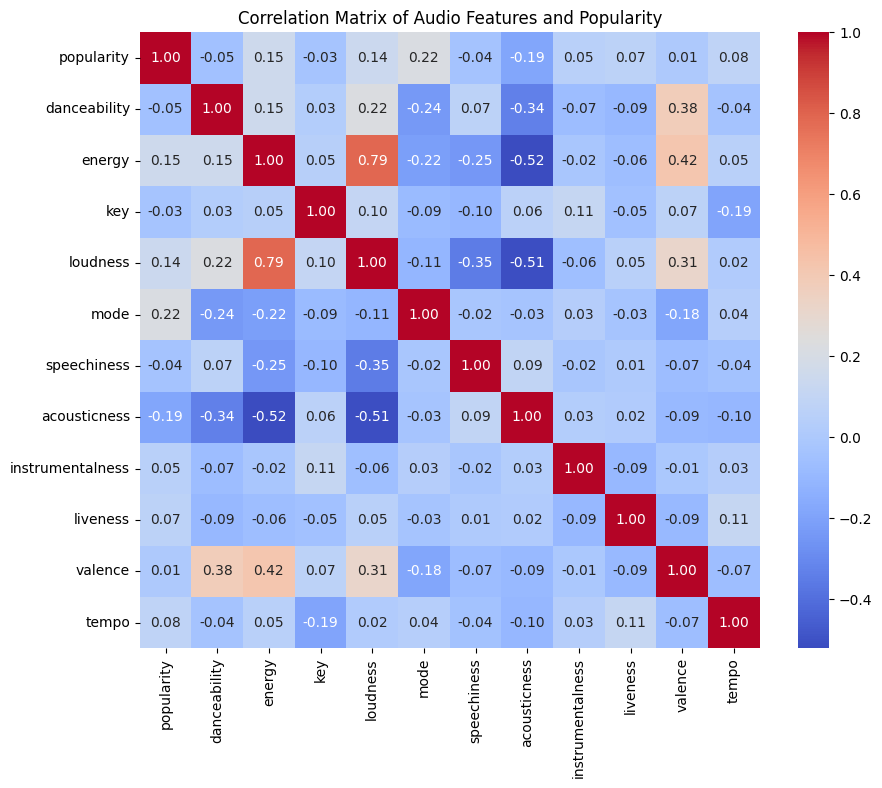

In [52]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Audio Features and Popularity")
plt.show()


It appears that there's no real coorelation with a song's audio features and its popularity. There's a slight positive correlation between popularity and mode, instrumentalness, and tempo. We can also see that valence, which is how positive a song is, is positively correlated to danceability, energy, and loudness. 

Popularity is a measure from the entire population, and may not be an accurate reflection of what type of songs I enjoy. I now want to analyze the song features from all my liked songs to determine if I gravitate towards a certain style. 

First, I will plot the audio features to see the data distribution

In [53]:
df.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,House/Techno,Funk,Jazz,Blues,Country,K-pop,Reggae,Electronic/Dance,Classical,Unknown Genre
count,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,...,1056.000000,1056.000000,1056.0,1056.0,1056.000000,1056.000000,1056.000000,1056.000000,1056.0,1056.000000
mean,42.047348,0.699601,0.730673,5.506629,-5.512588,0.549242,0.108307,0.144811,0.080933,0.192915,...,0.333333,0.006629,0.0,0.0,0.000947,0.232955,0.000947,0.304924,0.0,0.081439
std,27.231318,0.129204,0.163433,3.710361,2.020781,0.497805,0.093794,0.195830,0.209243,0.157635,...,0.471628,0.081186,0.0,0.0,0.030773,0.422914,0.030773,0.460593,0.0,0.273638
min,0.000000,0.208000,0.178000,0.000000,-13.400000,0.000000,0.025400,0.000038,0.000000,0.016200,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,22.000000,0.611750,0.624000,2.000000,-6.683250,0.000000,0.048800,0.010675,0.000000,0.091100,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,44.000000,0.711000,0.751500,6.000000,-5.335000,1.000000,0.069150,0.054550,0.000006,0.125000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,64.000000,0.798000,0.860000,9.000000,-4.083750,1.000000,0.126250,0.207250,0.005630,0.258250,...,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000
max,98.000000,0.983000,1.000000,11.000000,-0.425000,1.000000,0.621000,0.941000,0.958000,0.951000,...,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


For popularity, I can tell that most songs I've liked are not as popular, given that the 75th percentile is at 62 of 100. The mean value for danceability and energy are high at around .7 and .73,respectively, and the 25th percentile for both are at .61 and .62, respectively, so it's clear that I generally prefer to listen to songs with high energy and a good, rhythmic beat.

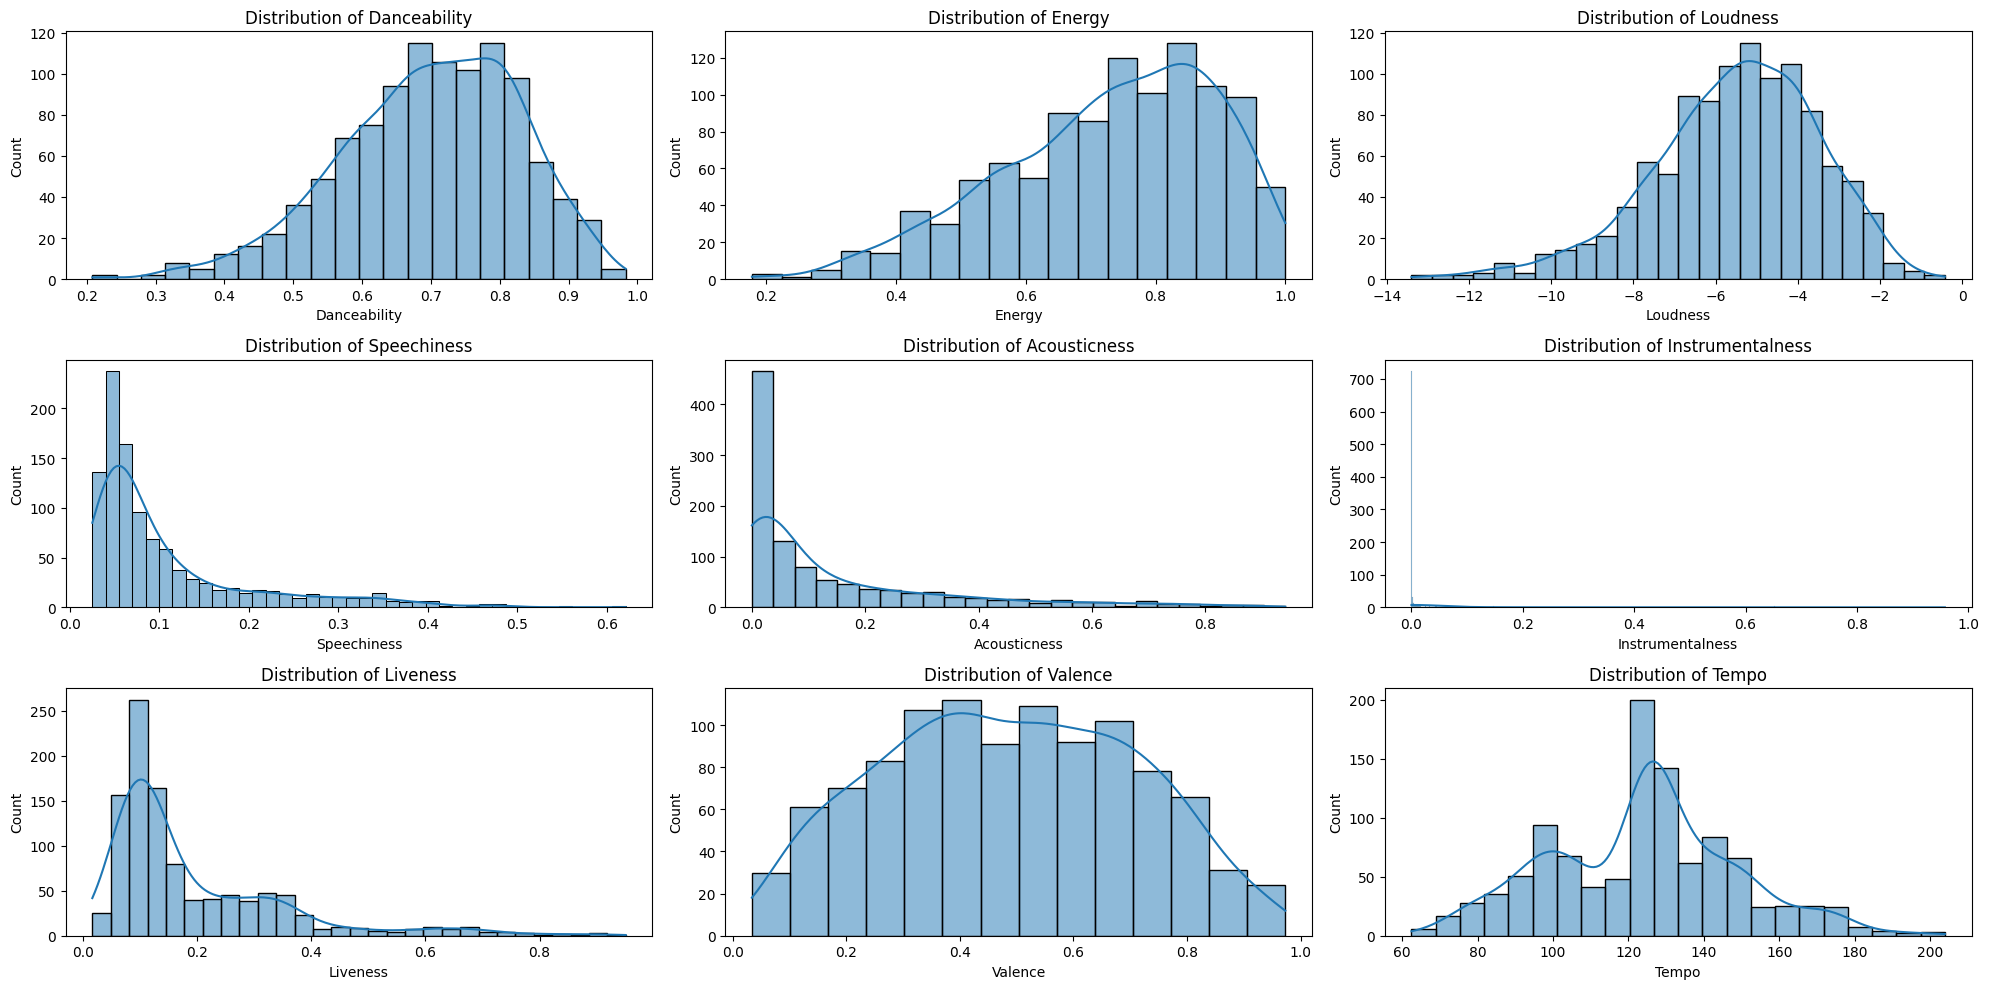

In [55]:
#generate histograms to get a sense of distribution for each feature

# List of audio features to analyze
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Plot histograms for each feature
plt.figure(figsize=(20, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)  # 3x3 grid of subplots
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())

plt.tight_layout()
plt.show()

From the histograms, I can see that danceability and energy have a somewhat normal distrubtion but also slightly left skewed, indicating I like more danceable and energetic tracks. Loudness has a slight left-skewed tail but otherwise normal distribution, and shows that most of the songs I enjoy listen to are not that loud (given the scale goes to -60dB). Speechiness, acousticness, instrumentalness, and liveness are all heavily right-skewed, indicating that most tracks have less words, are not live, and are not acououstic or instrumental in nature. Valence and tempo has a normal distribution, indicating a diverse range in positivity and tempo in the tracks. 

Next, I will use blox plots to visualize median, quantiles, and any outliers. 

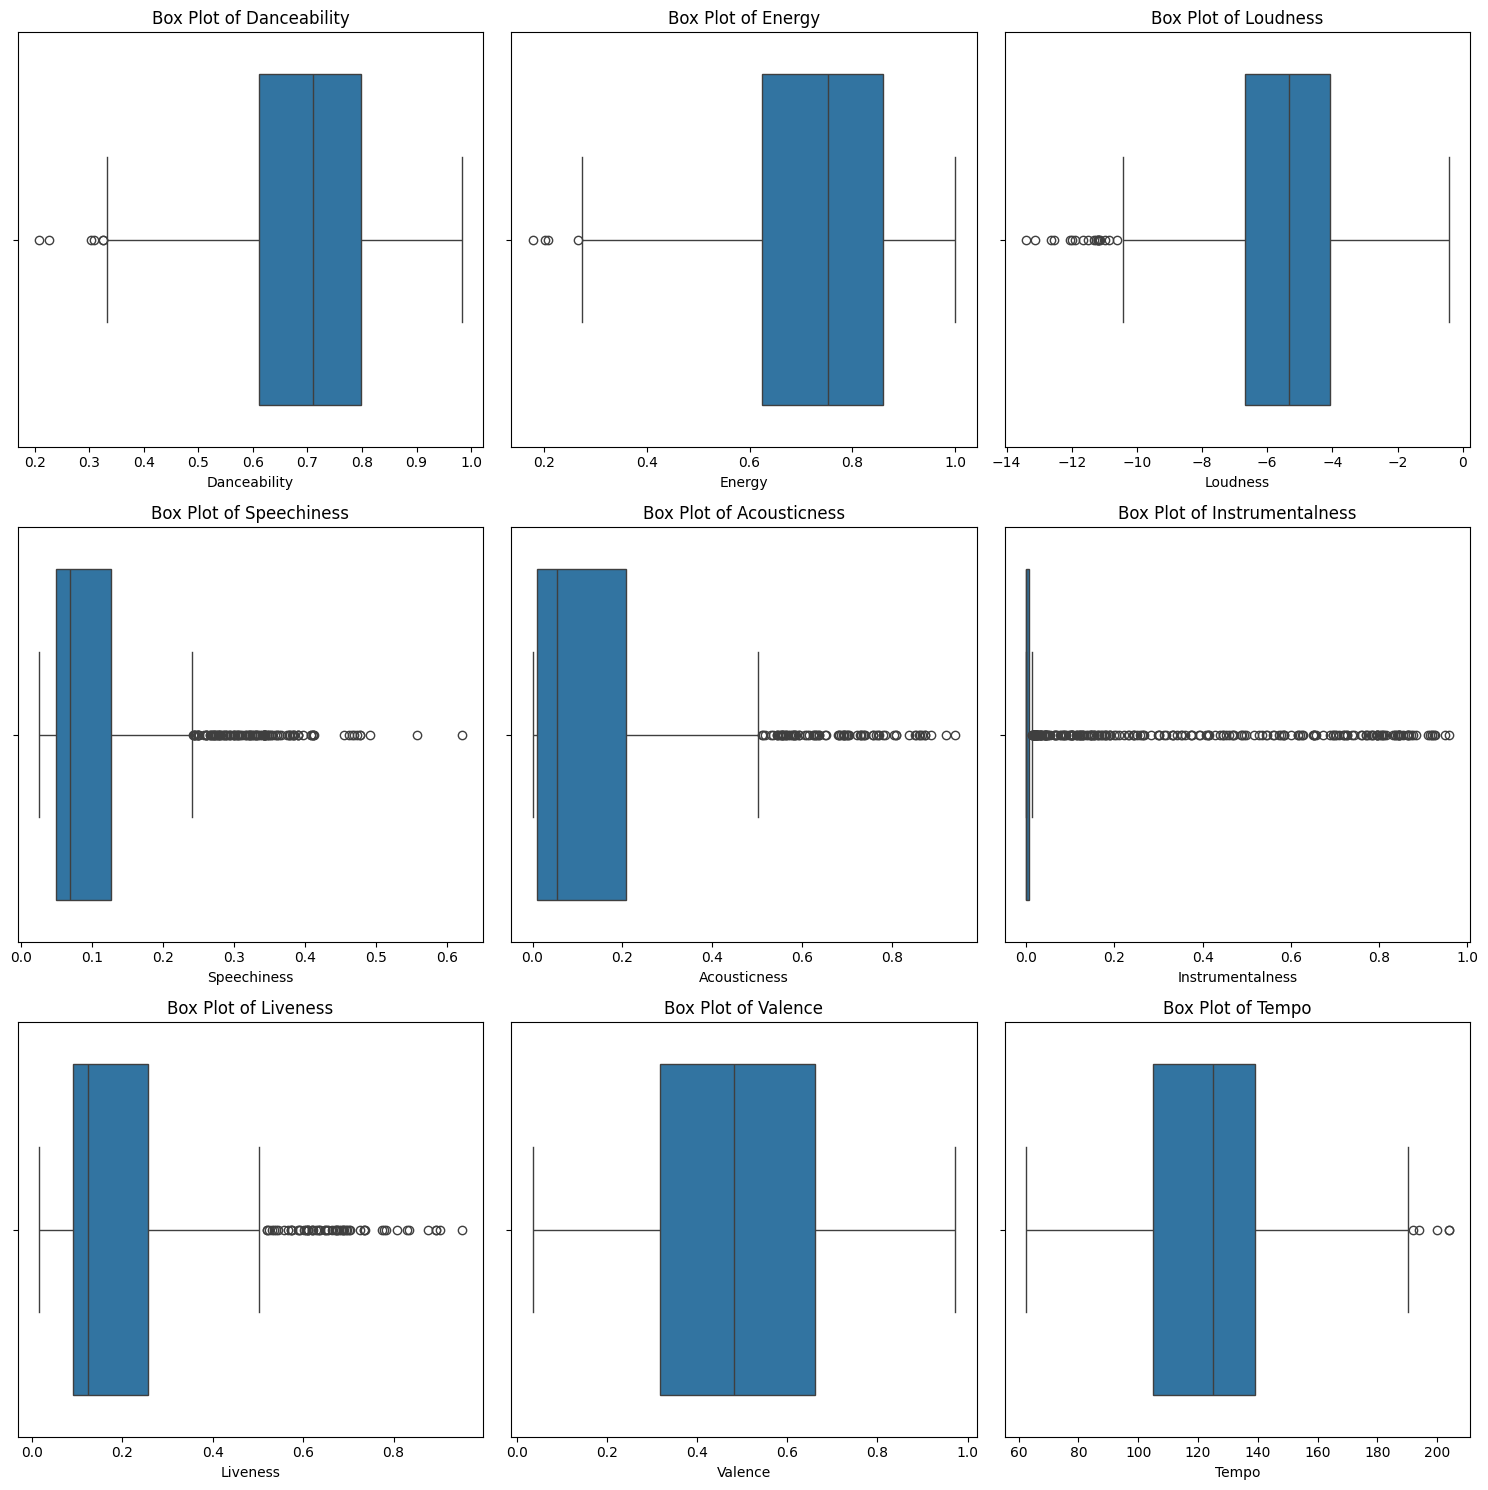

In [56]:
# Plot box plots for each feature
    
plt.figure(figsize=(15, 15))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)  
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())

plt.tight_layout()
plt.show()

Boxplots further support our results, with danceability, energy, and loudness being left-skewed, vlaence and tempo somewhat normal, and rest being left-skewed. 

Last part of the exploratory analysis is to check the correlation of the features

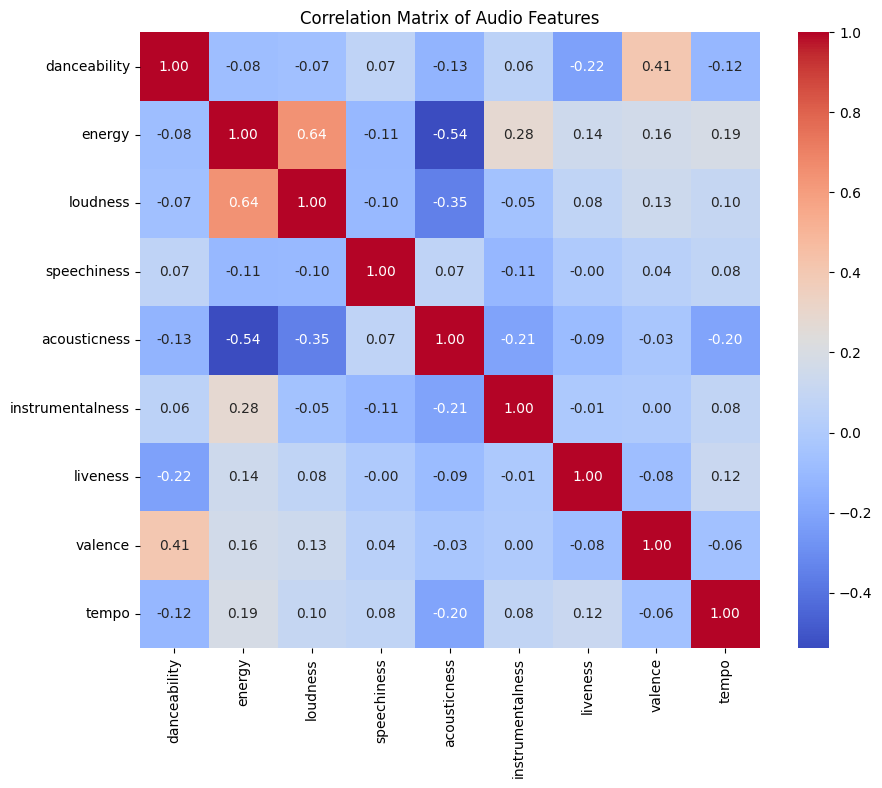

In [57]:
# Calculate the correlation matrix
corr_matrix = df[features].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Audio Features")
plt.show()

Energy and Loudness have a strong positive correlation, which is expected as lounder tracks are perceived as more energetic. Similarly, energy has a slight positive correlation with tempo, suggesting that faster songs are more energetic. Energy has a strong negative correlation with acousticness, suggesting tracks with higher acousticness tend to have lower energy. Likewise, acousticness and loudness have a negative correlation, indicating acoustic tracks are generally quieter. Valence shows a moderately positive correlation with danceability and slight positive correlation with energy, indicating that the tracks I like that are more positive are often more danceable and energetic. Tempo is slightly negatively correlated with acousticness and danceability, suggesting that acoustic songs have a slower tempo, and that tracks with slower tempos are better suitable for dancing. 

All in all, these correlation relationships are not too suprising and are somewhat intuitive. 

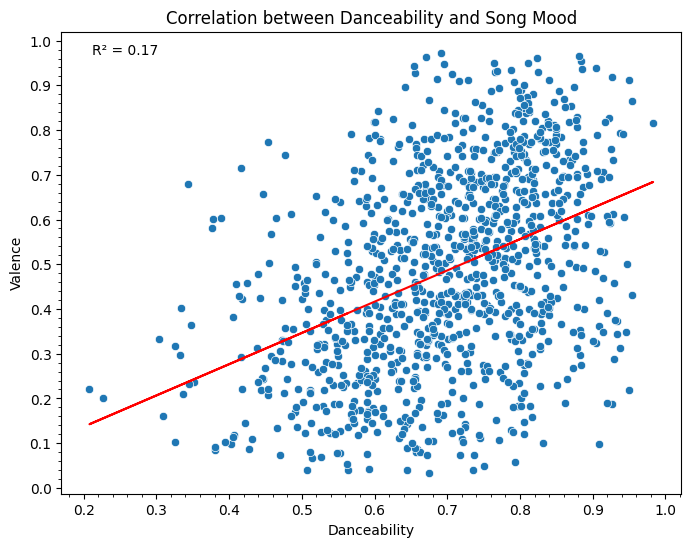

In [59]:
# Extracting danceability and valence
X = df['danceability'].values # Predictor variable
y = df['valence'].values  # Response variable

X = X.reshape(X.shape[0], 1)
y = y.reshape(y.shape[0], 1)

# Create a linear regression model
model = linear_model.LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate R^2 value
r_squared = model.score(X, y)

# Scatterplot with fitted line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['danceability'], y=df['valence'])
plt.plot(df['danceability'], y_pred, color='red')  # Fitted line
plt.title('Correlation between Danceability and Song Mood')
plt.xlabel('Danceability')
plt.ylabel('Valence')
plt.text(0.05, 0.95, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes)  # Display R² value on the plot

# Adding smaller ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

plt.show()

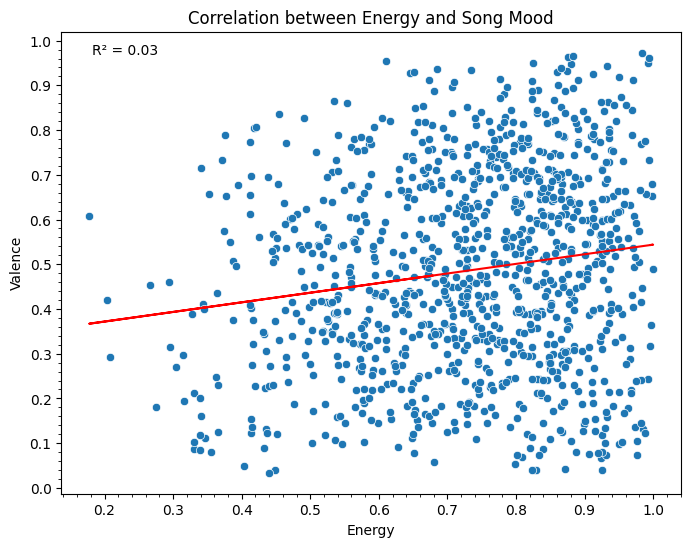

In [60]:
# Extracting danceability and valence
X = df['energy'].values # Predictor variable
y = df['valence'].values  # Response variable

X = X.reshape(X.shape[0], 1)
y = y.reshape(y.shape[0], 1)

# Create a linear regression model
model = linear_model.LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate R^2 value
r_squared = model.score(X, y)

# Scatterplot with fitted line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['energy'], y=df['valence'])
plt.plot(df['energy'], y_pred, color='red')  # Fitted line
plt.title('Correlation between Energy and Song Mood')
plt.xlabel('Energy')
plt.ylabel('Valence')
plt.text(0.05, 0.95, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes)  # Display R² value on the plot

# Adding smaller ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

plt.show()

Lastly, I want to look at the distribution of genres within my liked songs to see which are my top broader categories.

/var/folders/47/33tnrjb10llgqwp7jq911cgh0000gn/T/ipykernel_13113/2693916724.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")


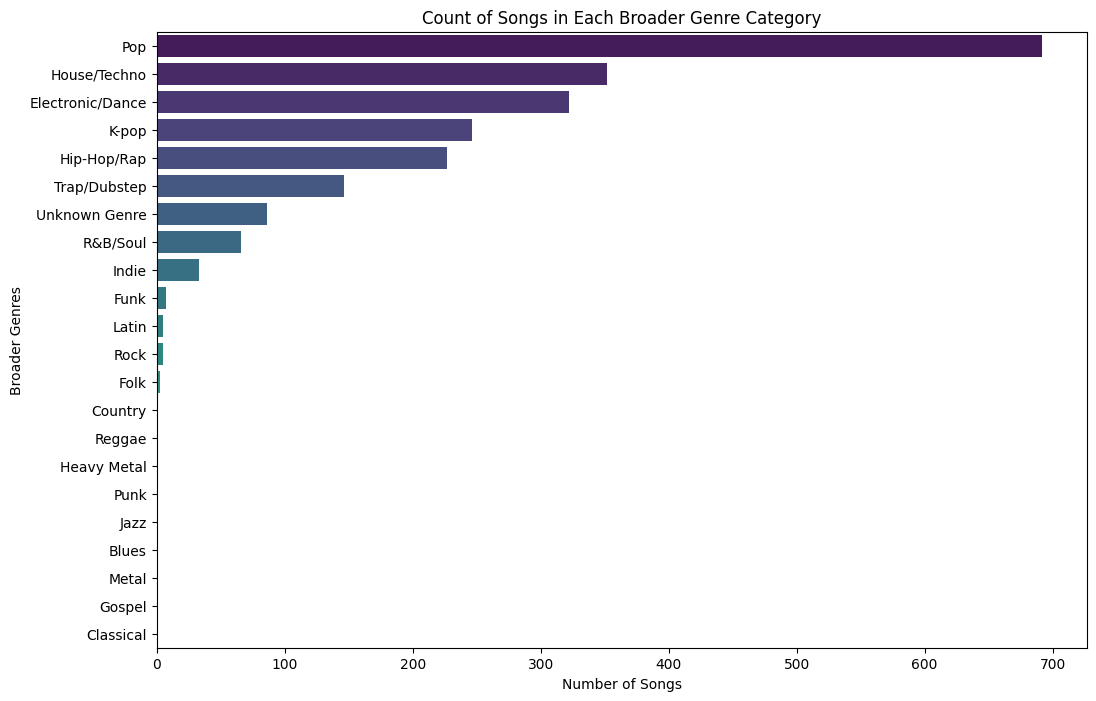

In [62]:
# Summing up the count for each broader genre category
genre_counts = liked_broader_genres_df.sum().sort_values(ascending=False)

# Create a countplot with a valid color palette
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")
plt.title("Count of Songs in Each Broader Genre Category")
plt.xlabel("Number of Songs")
plt.ylabel("Broader Genres")
plt.show()

I next want to see if any of these categories are correlated with audio features.

In [75]:
audio_features = df[features]

# Merge the audio features with the one-hot encoded genre data
audio_genres_merged = pd.concat([audio_features, liked_broader_genres_df], axis=1)

# Calculate the correlation matrix
correlation_matrix = audio_genres_merged.corr()

# Extract the correlations between genres and audio features
# We are interested in the last 'len(broader_genres_df.columns)' rows, which correspond to the genres
genre_audio_correlations = correlation_matrix.iloc[-len(broader_genres_df.columns):, :]

# Display the correlations for review
genre_audio_correlations.head()  # Displaying only first few rows for brevity


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,R&B/Soul,...,House/Techno,Funk,Jazz,Blues,Country,K-pop,Reggae,Electronic/Dance,Classical,Unknown Genre
R&B/Soul,0.012884,-0.224287,-0.148987,0.126158,0.183100,-0.085214,-0.085403,-0.000181,-0.083170,1.000000,...,-0.174275,-0.021092,NaN,NaN,-0.007949,-0.068254,-0.007949,-0.137024,NaN,-0.076881
Indie,0.031320,-0.100393,-0.049361,-0.005395,0.060055,-0.058591,0.031037,0.014413,-0.048150,0.043563,...,-0.127000,-0.014672,NaN,NaN,-0.005530,-0.098979,-0.005530,-0.107137,NaN,-0.053479
Trap/Dubstep,-0.000675,0.042183,0.098582,0.117891,-0.129002,0.004455,0.062058,-0.116973,0.052647,-0.001417,...,0.042679,-0.032720,NaN,NaN,-0.012332,-0.220740,0.076863,0.199522,NaN,-0.119267
Gospel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Metal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


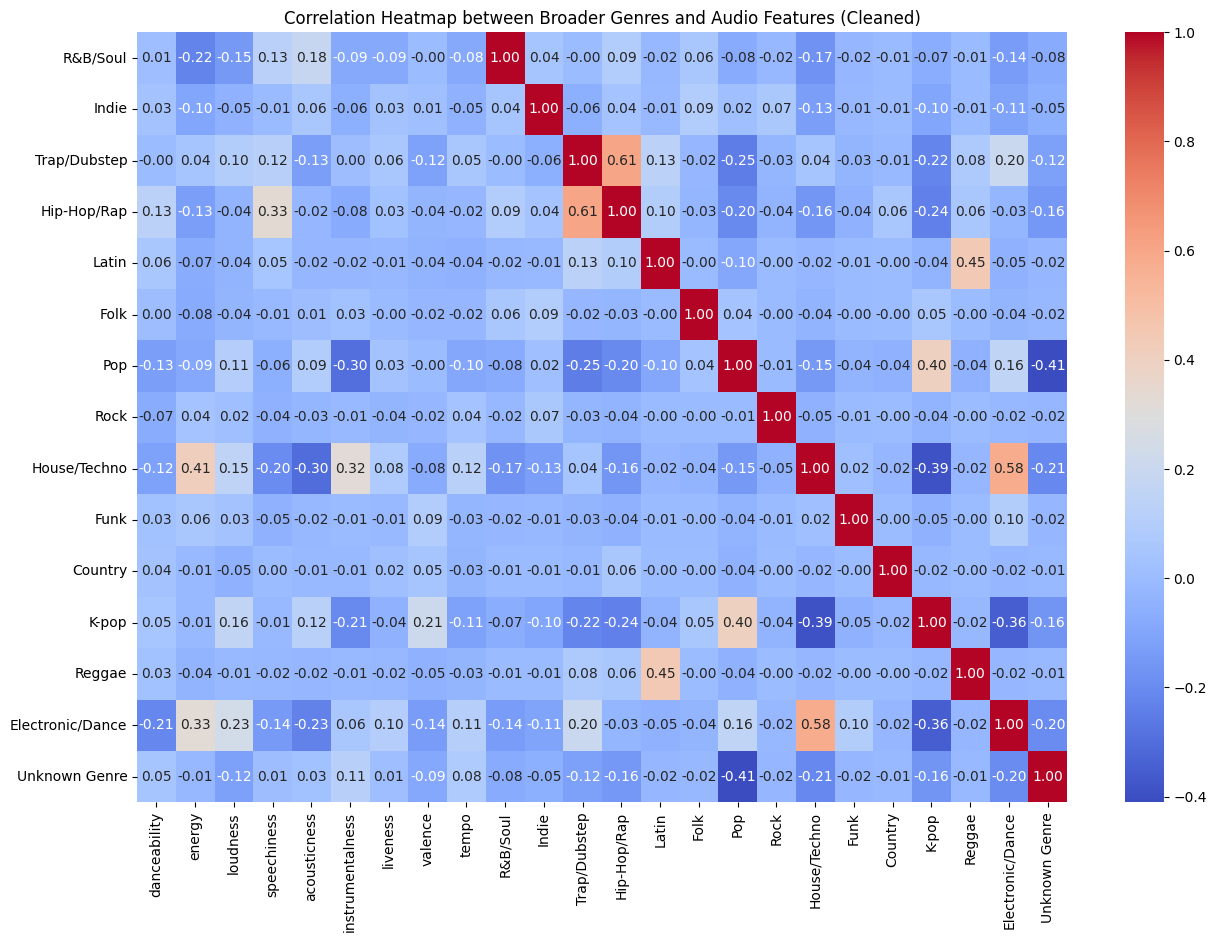

In [77]:
# Removing rows and columns with NaN values (genres with insufficient data) for clearer visualization
genre_audio_correlations_cleaned = genre_audio_correlations.dropna(axis=0, how='all').dropna(axis=1, how='all')

# Plotting the cleaned correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(genre_audio_correlations_cleaned, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap between Broader Genres and Audio Features (Cleaned)")
plt.show()


Popularity: 'Hip-Hop/Rap' and 'K-pop' show a positive correlation, suggesting these genres are associated with more popular songs in your dataset.

Danceability: Genres like 'Hip-Hop/Rap' and 'Latin' have a positive correlation with danceability, indicating these genres tend to feature more danceable tracks.

Energy: 'House/Techno' and 'Dance' genres show a strong positive correlation with energy, which is typical for these high-tempo, upbeat genres.

Loudness: Similarly, 'House/Techno' and 'Dance' genres have a positive correlation with loudness.

Speechiness: 'Hip-Hop/Rap' has a significantly high positive correlation with speechiness, which aligns with the vocal nature of rap music.

### Now moving on to disliked songs

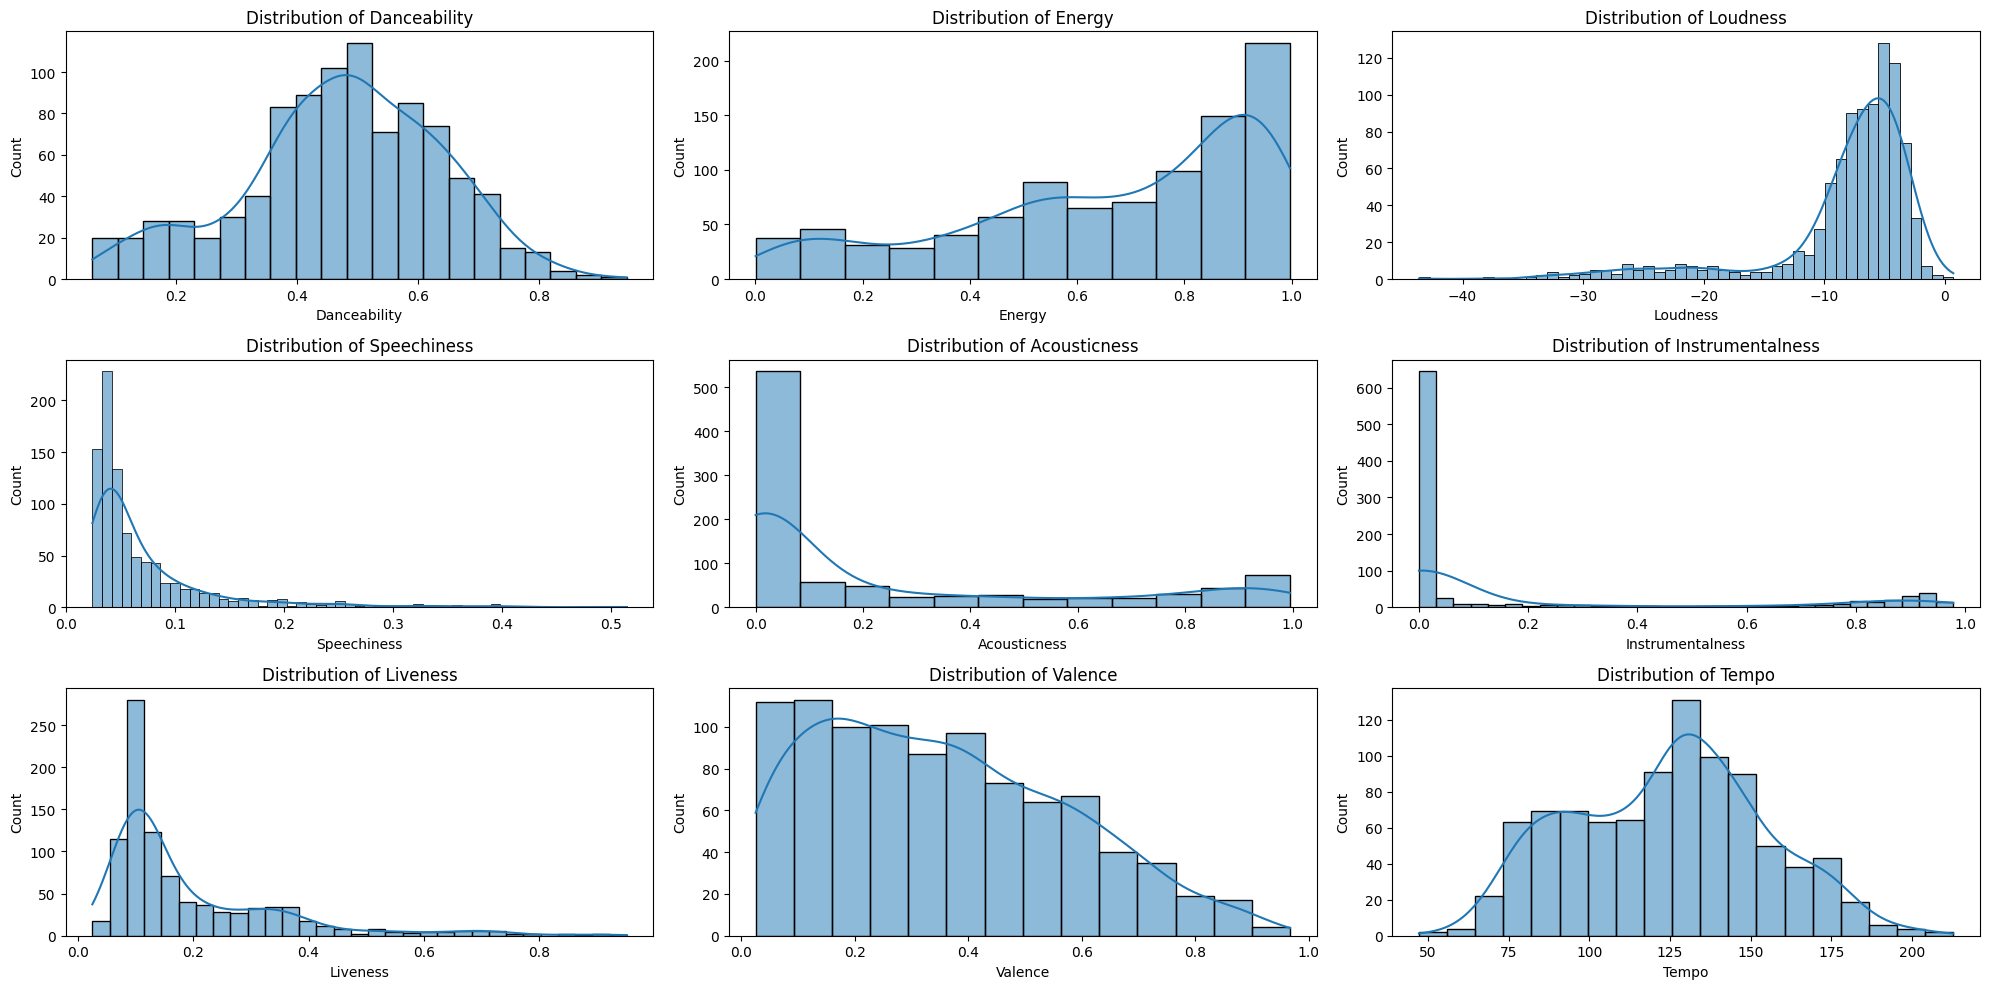

In [78]:
#generate histograms to get a sense of distribution for each feature

# List of audio features to analyze
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Plot histograms for each feature
plt.figure(figsize=(20, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)  # 3x3 grid of subplots
    sns.histplot(dislikes_df[feature], kde=True)
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())

plt.tight_layout()
plt.show()

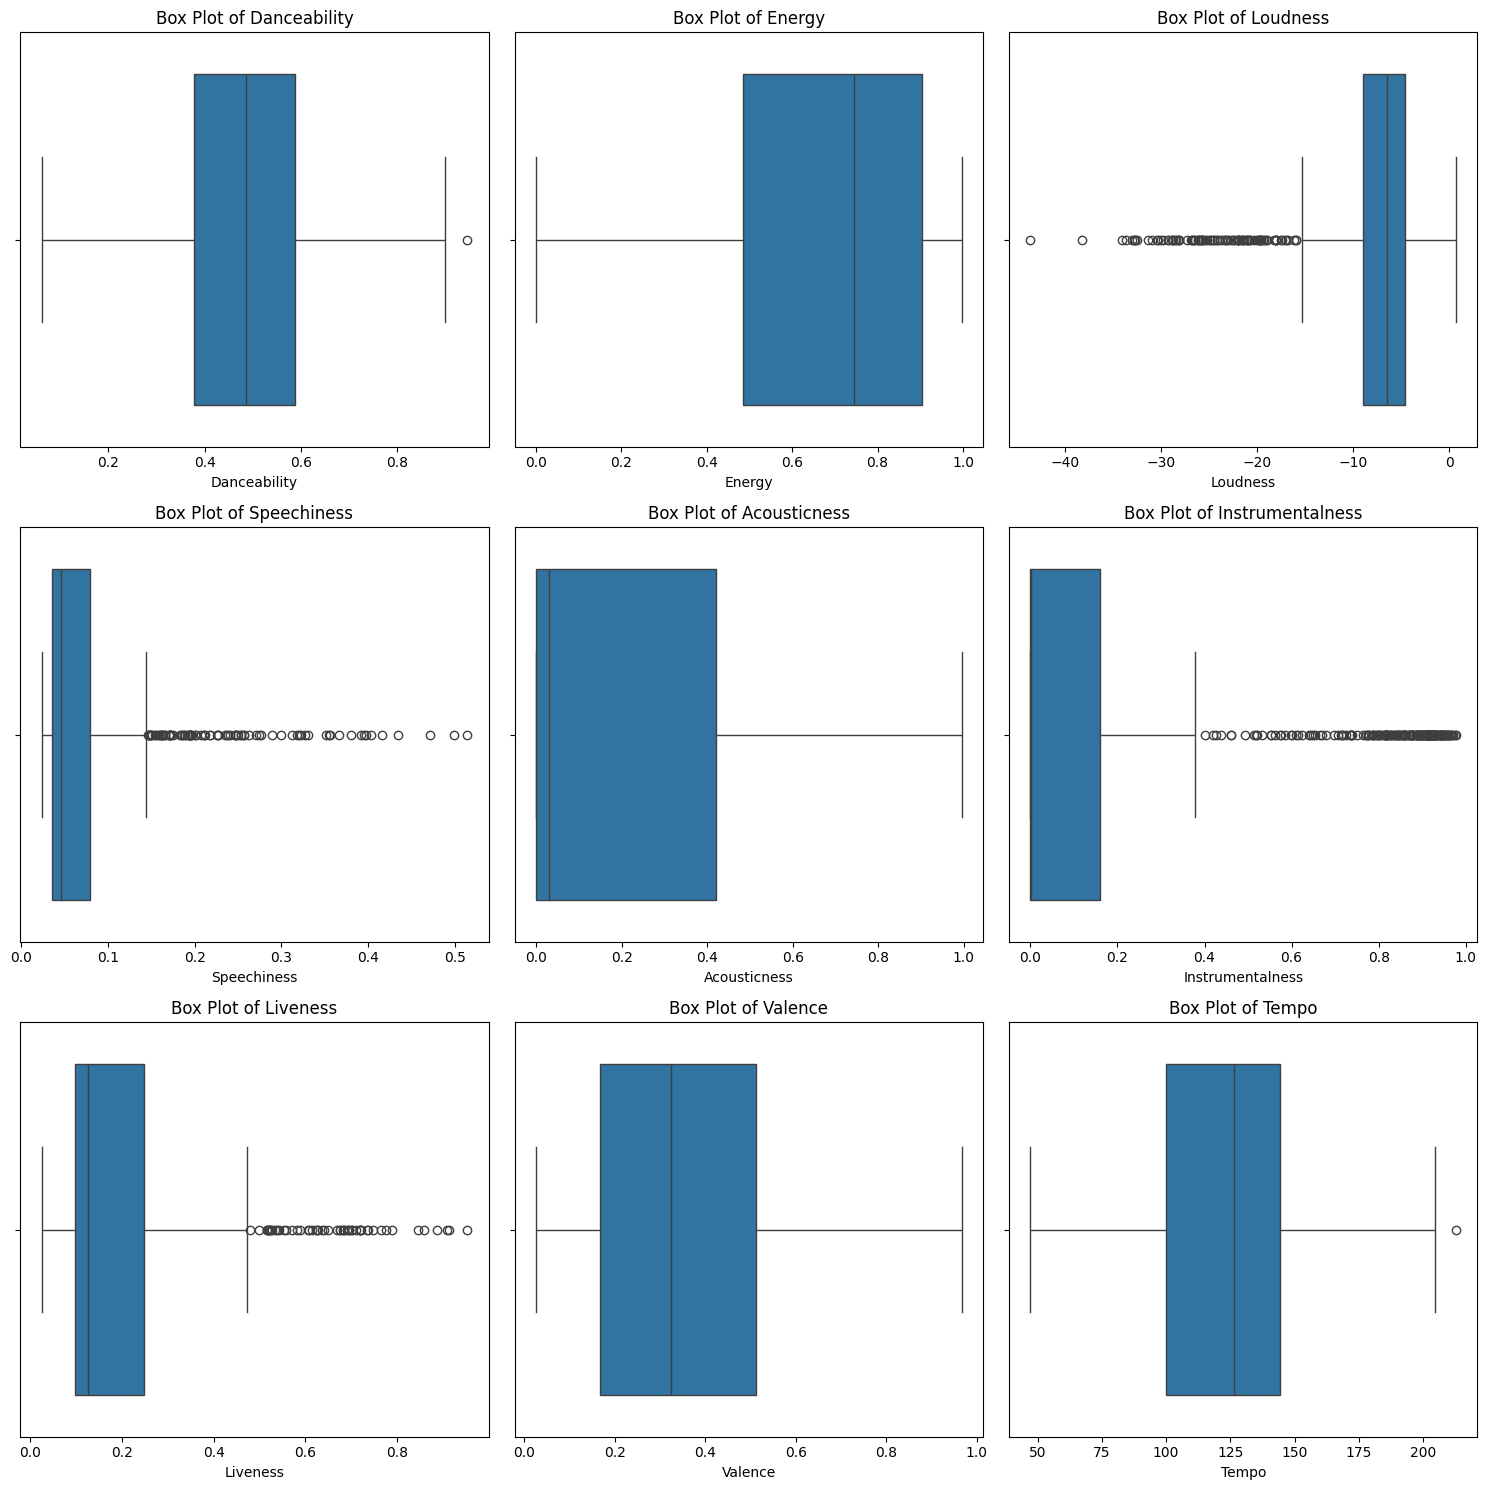

In [79]:
# Plot box plots for each feature
    
plt.figure(figsize=(15, 15))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)  
    sns.boxplot(x=dislikes_df[feature])
    plt.title(f'Box Plot of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())

plt.tight_layout()
plt.show()

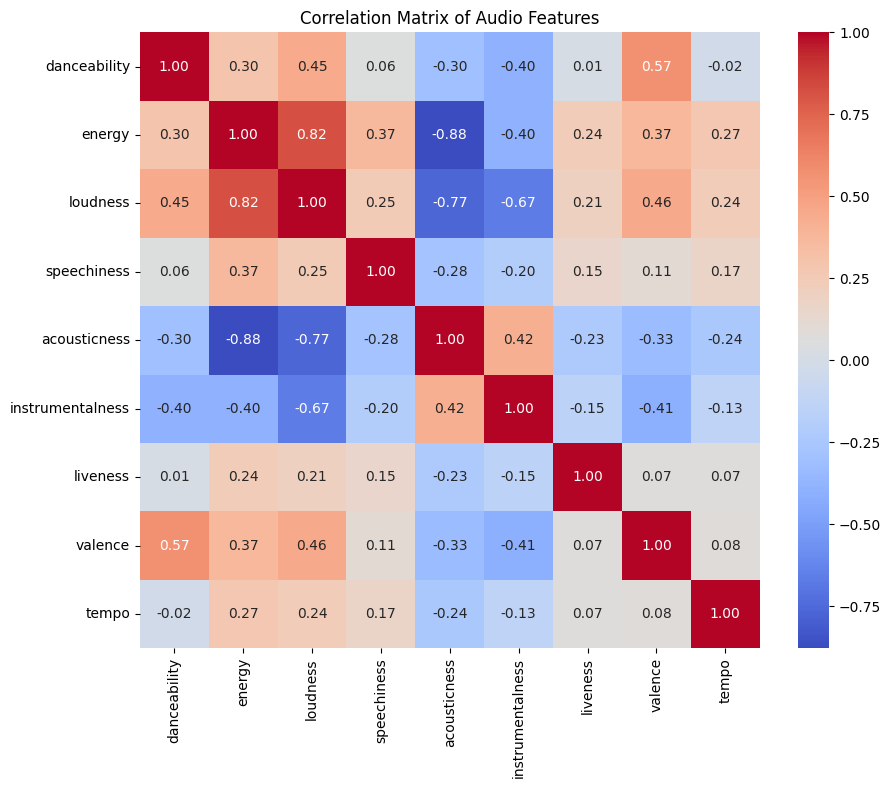

In [80]:
# Calculate the correlation matrix
corr_matrix = dislikes_df[features].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Audio Features")
plt.show()

# Training a model with linear regression

For training these models, I will give higher weight to the F1 score and accuracy, as it is more improtant to have a good balance between precision and recall in song recommendations as well as accurate predicitons. In this case, having a false positive or false negative are not costly to the problem at hand (whether I like or dislike a song).

First I will split the data for training and testing.

In [234]:
from sklearn.model_selection import train_test_split

# Dropping unnecessary columns
columns_to_drop = ['artist_name', 'track_name', 'popularity', 'track_id', 'artist_id', 'artist_genre', 'broader_genres', 'mode', 'key', 'time_signature', 'duration_ms']
df_cleaned = all_df.drop(columns=columns_to_drop)

# Splitting the data into features (X) and target (y)
X = df_cleaned.drop('preference', axis=1)
y = df_cleaned['preference']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1588, 31), (397, 31), (1588,), (397,))

The dataset has been split into training (1588 samples) and testing sets (397 samples), with each set containing 36 features.

In [170]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Model Training
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")
print(f"ROC AUC: {roc_auc * 100:.2f}%")

Accuracy: 90.18%
Precision: 90.24%
Recall: 90.69%
F1: 90.46%
ROC AUC: 96.86%


These metrics suggests the model is reasonably effective, but I will try some hyperparameter turning to see if these stats can be improved.

In [171]:
# Here is the code for hyperparameter tuning using GridSearchCV. You can run this on your system with more computational resources.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setting up the hyperparameter grid for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # Regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # Algorithms to use in the optimization problem
    'max_iter': [100, 200, 500, 1000] # Maximum number of iterations taken for the solvers to converge
}

# Initializing the Grid Search with Logistic Regression model
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=2)

# Code for performing hyperparameter tuning
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ............C=0.001, max_iter=100, solver=newton-cg; total time=   0.1s
[CV] END ............C=0.001, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.001, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, max_iter=100, so

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=100, solver=sag; total time=   0.1s
[CV] END ..................C=0.001, max_iter=100, solver=sag; total time=   0.1s
[CV] END ..................C=0.001, max_iter=100, solver=sag; total time=   0.1s
[CV] END ..................C=0.001, max_iter=100, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=100, solver=sag; total time=   0.1s
[CV] END .................C=0.001, max_iter=100, solver=saga; total time=   0.1s
[CV] END .................C=0.001, max_iter=100, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=100, solver=saga; total time=   0.1s
[CV] END .................C=0.001, max_iter=100, solver=saga; total time=   0.1s
[CV] END .................C=0.001, max_iter=100, solver=saga; total time=   0.1s
[CV] END ............C=0.001, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.001, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ................C=0

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=200, solver=sag; total time=   0.1s
[CV] END ..................C=0.001, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=200, solver=sag; total time=   0.1s
[CV] END ..................C=0.001, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=200, solver=sag; total time=   0.1s
[CV] END .................C=0.001, max_iter=200, solver=saga; total time=   0.1s
[CV] END .................C=0.001, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=200, solver=saga; total time=   0.1s
[CV] END .................C=0.001, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=200, solver=saga; total time=   0.1s
[CV] END ............C=0.001, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.001, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=500, solver=lbfgs; total time=   0.2s
[CV] END ................C=0.001, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=500, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=500, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=500, solver=sag; total time=   0.3s
[CV] END .................C=0.001, max_iter=500, solver=saga; total time=   0.1s
[CV] END .................C=0.001, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=500, solver=saga; total time=   0.3s
[CV] END .................C=0.001, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=500, solver=saga; total time=   0.3s
[CV] END ...........C=0.001, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...........C=0.001, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...........C=0.001, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...........C=0.001, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...........C=0.001, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...............C=0.001, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.001, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.001, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.001, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.001, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...........C=0.001, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END ...........C=0.001,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=1000, solver=sag; total time=   0.5s
[CV] END .................C=0.001, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=1000, solver=sag; total time=   0.4s
[CV] END ................C=0.001, max_iter=1000, solver=saga; total time=   0.1s
[CV] END ................C=0.001, max_iter=1000, solver=saga; total time=   0.1s
[CV] END ................C=0.001, max_iter=1000, solver=saga; total time=   0.3s
[CV] END ................C=0.001, max_iter=1000, solver=saga; total time=   0.1s
[CV] END ................C=0.001, max_iter=1000, solver=saga; total time=   0.3s
[CV] END .............C=0.01, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END .................C=

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.01, max_iter=100, solver=sag; total time=   0.1s
[CV] END ...................C=0.01, max_iter=100, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.01, max_iter=100, solver=sag; total time=   0.1s
[CV] END ...................C=0.01, max_iter=100, solver=sag; total time=   0.1s
[CV] END ...................C=0.01, max_iter=100, solver=sag; total time=   0.1s
[CV] END ..................C=0.01, max_iter=100, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=100, solver=saga; total time=   0.1s
[CV] END ..................C=0.01, max_iter=100, solver=saga; total time=   0.1s
[CV] END ..................C=0.01, max_iter=100, solver=saga; total time=   0.1s
[CV] END ..................C=0.01, max_iter=100, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .............C=0.01, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.01, max_iter=200, solver=sag; total time=   0.1s
[CV] END ...................C=0.01, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.01, max_iter=200, solver=sag; total time=   0.1s
[CV] END ...................C=0.01, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=   0.1s
[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=   0.1s
[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=   0.1s
[CV] END .............C=0.01, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END .............C=0.01, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=500, solver=saga; total time=   0.3s
[CV] END ............C=0.01, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.01, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.01, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.01, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.01, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.01, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.01, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.01, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.01, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.01, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.01, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END ............C=0.01,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ..............C=0.1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.1, max_iter=100, solver=sag; total time=   0.1s
[CV] END ....................C=0.1, max_iter=100, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=100, solver=sag; total time=   0.1s
[CV] END ....................C=0.1, max_iter=100, solver=sag; total time=   0.1s
[CV] END ....................C=0.1, max_iter=100, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=100, solver=saga; total time=   0.1s
[CV] END ...................C=0.1, max_iter=100, solver=saga; total time=   0.1s
[CV] END ...................C=0.1, max_iter=100, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=100, solver=saga; total time=   0.1s
[CV] END ...................C=0.1, max_iter=100, solver=saga; total time=   0.1s
[CV] END ..............C=0.1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=newton-cg; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..............C=0.1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ..................C=0.1, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.1, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.1, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.1, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.1, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..............C=0.1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=liblinear; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=200, solver=sag; total time=   0.1s
[CV] END ....................C=0.1, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=200, solver=sag; total time=   0.1s
[CV] END ....................C=0.1, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=200, solver=sag; total time=   0.1s
[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=   0.1s
[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=   0.1s
[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=   0.1s
[CV] END ..............C=0.1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=newton-cg; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..............C=0.1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ..............C=0.1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   0.3s
[CV] END .............C=0.1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .................C=0.1, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.1, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END .................C=0.1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END .................C=0.1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END .............C=0.1, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END .............C=0.1,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   0.5s
[CV] END ................C=1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ................C=1

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ................C=1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ......................C=1, max_iter=100, solver=sag; total time=   0.1s
[CV] END ......................C=1, max_iter=100, solver=sag; total time=   0.1s
[CV] END ......................C=1, max_iter=100, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=1, max_iter=100, solver=sag; total time=   0.1s
[CV] END ......................C=1, max_iter=100, solver=sag; total time=   0.1s
[CV] END .....................C=1, max_iter=100, solver=saga; total time=   0.1s
[CV] END .....................C=1, max_iter=100, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=100, solver=saga; total time=   0.1s
[CV] END .....................C=1, max_iter=100, solver=saga; total time=   0.1s
[CV] END .....................C=1, max_iter=100, solver=saga; total time=   0.1s
[CV] END ................C=1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=newton-cg; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................C=1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ................C=1, max_iter=200, solver=liblinear; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................C=1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ......................C=1, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=1, max_iter=200, solver=sag; total time=   0.1s
[CV] END ......................C=1, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=1, max_iter=200, solver=sag; total time=   0.1s
[CV] END ......................C=1, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=200, solver=saga; total time=   0.1s
[CV] END .....................C=1, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=200, solver=saga; total time=   0.1s
[CV] END .....................C=1, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=200, solver=saga; total time=   0.1s
[CV] END ................C=1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ................C=1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=liblinear; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=1, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=1, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=1, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=1, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=1, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=500, solver=saga; total time=   0.3s
[CV] END ...............C=1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...............C=1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...............C=1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...............C=1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...............C=1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...................C=1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ...................C=1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ...................C=1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ...................C=1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ...................C=1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ...............C=1, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END ...............C=1,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=1, max_iter=1000, solver=saga; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=1, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=1, max_iter=1000, solver=saga; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=1, max_iter=1000, solver=saga; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

[CV] END ....................C=1, max_iter=1000, solver=saga; total time=   0.6s
[CV] END ...............C=10, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ...................C=10, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=100, solver=lbfgs; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ...................C=10, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END .....................C=10, max_iter=100, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=100, solver=sag; total time=   0.1s
[CV] END .....................C=10, max_iter=100, solver=sag; total time=   0.1s
[CV] END .....................C=10, max_iter=100, solver=sag; total time=   0.1s
[CV] END .....................C=10, max_iter=100, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=100, solver=saga; total time=   0.1s
[CV] END ....................C=10, max_iter=100, solver=saga; total time=   0.1s
[CV] END ....................C=10, max_iter=100, solver=saga; total time=   0.1s
[CV] END ....................C=10, max_iter=100, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=10, max_iter=100, solver=saga; total time=   0.1s
[CV] END ...............C=10, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=200, solver=sag; total time=   0.1s
[CV] END .....................C=10, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=200, solver=sag; total time=   0.1s
[CV] END .....................C=10, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=200, solver=sag; total time=   0.1s
[CV] END ....................C=10, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=200, solver=saga; total time=   0.1s
[CV] END ....................C=10, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=200, solver=saga; total time=   0.1s
[CV] END ....................C=10, max_iter=200, solver=saga; total time=   0.1s
[CV] END ...............C=10, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=newton-cg; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   0.2s
[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ...............C=10, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=liblinear; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=500, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=500, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=500, solver=saga; total time=   0.3s
[CV] END ..............C=10, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ..............C=10, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ..............C=10, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ..............C=10, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ..............C=10, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ..................C=10, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ..................C=10, max_iter=1000, solver=lbfgs; total time=   0.2s
[CV] END ..................C=10, max_iter=1000, solver=lbfgs; total time=   0.2s
[CV] END ..................C=10, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ..................C=10, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ..............C=10, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END ..............C=10,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=10, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=10, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=10, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=10, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=10, max_iter=1000, solver=saga; total time=   0.5s
[CV] END ..............C=100, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=100, solver=newton-cg; total time=   0.1s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..............C=100, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ..............C=100

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ....................C=100, max_iter=100, solver=sag; total time=   0.1s
[CV] END ....................C=100, max_iter=100, solver=sag; total time=   0.1s
[CV] END ....................C=100, max_iter=100, solver=sag; total time=   0.1s
[CV] END ....................C=100, max_iter=100, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=100, max_iter=100, solver=sag; total time=   0.1s
[CV] END ...................C=100, max_iter=100, solver=saga; total time=   0.1s
[CV] END ...................C=100, max_iter=100, solver=saga; total time=   0.1s
[CV] END ...................C=100, max_iter=100, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=100, solver=saga; total time=   0.1s
[CV] END ...................C=100, max_iter=100, solver=saga; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=newton-cg; total time=   0.1s
[CV] END ..................C=100, max_iter=200, solver=lbfgs; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ..................C=100, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..................C=100, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..................C=100, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=200, solver=liblinear; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..............C=100, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ....................C=100, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=100, max_iter=200, solver=sag; total time=   0.1s
[CV] END ....................C=100, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=100, max_iter=200, solver=sag; total time=   0.1s
[CV] END ....................C=100, max_iter=200, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=200, solver=saga; total time=   0.1s
[CV] END ...................C=100, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=200, solver=saga; total time=   0.1s
[CV] END ...................C=100, max_iter=200, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=200, solver=saga; total time=   0.1s
[CV] END ..............C=100, max_iter=500, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=500, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=500, solver=newton-cg; total time=   0.1s
[CV] END ..................C=100, max_iter=500, solver=lbfgs; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ..................C=100, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ..................C=100, max_iter=500, solver=lbfgs; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ..................C=100, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ..................C=100, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ..............C=100, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=500, solver=liblinear; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=100, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=100, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=100, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=100, max_iter=500, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=100, max_iter=500, solver=sag; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=500, solver=saga; total time=   0.3s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=500, solver=saga; total time=   0.3s
[CV] END .............C=100, max_iter=1000, solver=newton-cg; total time=   0.1s
[CV] END .............C=100, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=100, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=100, max_iter=1000, solver=newton-cg; total time=   0.1s
[CV] END .............C=100, max_iter=1000, solver=newton-cg; total time=   0.1s
[CV] END .................C=100, max_iter=1000, solver=lbfgs; total time=   0.2s
[CV] END .................C=100, max_iter=1000, solver=lbfgs; total time=   0.2s
[CV] END .................C=100, max_iter=1000, solver=lbfgs; total time=   0.2s
[CV] END .................C=100, max_iter=1000, solver=lbfgs; total time=   0.2s
[CV] END .................C=100, max_iter=1000, solver=lbfgs; total time=   0.2s
[CV] END .............C=100, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END .............C=100,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=1000, solver=sag; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=1000, solver=sag; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=1000, solver=sag; total time=   0.4s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=1000, solver=sag; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=100, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=100, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=100, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=100, max_iter=1000, solver=saga; total time=   0.5s
[CV] END ..................C=100, max_iter=1000, solver=saga; total time=   0.5s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 500, 1000],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy', verbose=2)

In [172]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params, best_score

({'C': 100, 'max_iter': 200, 'solver': 'lbfgs'}, 0.8967382893875365)

In [173]:
# Incorporating the best parameters from hyperparameter tuning into the logistic regression model

# Best parameters obtained from tuning
best_params = {'C': 100, 'max_iter': 200, 'solver': 'lbfgs'}

# Retraining the logistic regression model with the best parameters
optimized_log_reg = LogisticRegression(C=best_params['C'], max_iter=best_params['max_iter'], solver=best_params['solver'], random_state=42)
optimized_log_reg.fit(X_train, y_train)

# Predicting on the test set with the optimized model
y_pred_optimized = optimized_log_reg.predict(X_test)
y_pred_proba_optimized = optimized_log_reg.predict_proba(X_test)[:, 1]

# Evaluating the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

print(f"Accuracy: {accuracy_optimized * 100:.2f}%")
print(f"Precision: {precision_optimized * 100:.2f}%")
print(f"Recall: {recall_optimized * 100:.2f}%")
print(f"F1: {f1_optimized * 100:.2f}%")
print(f"ROC AUC: {roc_auc_optimized * 100:.2f}%")

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 90.93%
Precision: 90.38%
Recall: 92.16%
F1: 91.26%
ROC AUC: 97.08%


There isn't huge improvement but we see increases overall, particularly better recall and F1. The model is effective at predicting whether I will like a song. However, I want to see if using PCA dimensionality reduction to reduce the number of features can improve the model. 

In [215]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the features before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA
# We'll start by retaining 95% of the variance to see how many components that gives us
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Checking the number of components
n_components = pca.n_components_

n_components, X_train_pca.shape, X_test_pca.shape

(25, (1588, 25), (397, 25))

In [216]:
# Retraining the logistic regression model using the principal components from PCA

# Reinitializing the logistic regression model with the optimized parameters
optimized_log_reg_pca = LogisticRegression(C=best_params['C'], max_iter=best_params['max_iter'], solver=best_params['solver'], random_state=42)

# Retraining the model with the PCA-transformed data
optimized_log_reg_pca.fit(X_train_pca, y_train)

# Predicting on the PCA-transformed test set
y_pred_optimized_pca = optimized_log_reg_pca.predict(X_test_pca)
y_pred_proba_optimized_pca = optimized_log_reg_pca.predict_proba(X_test_pca)[:, 1]

# Evaluating the optimized model trained on PCA components
accuracy_optimized_pca = accuracy_score(y_test, y_pred_optimized_pca)
precision_optimized_pca = precision_score(y_test, y_pred_optimized_pca)
recall_optimized_pca = recall_score(y_test, y_pred_optimized_pca)
f1_optimized_pca = f1_score(y_test, y_pred_optimized_pca)
roc_auc_optimized_pca = roc_auc_score(y_test, y_pred_proba_optimized_pca)

print(f"Accuracy: {accuracy_optimized_pca * 100:.2f}%")
print(f"Precision: {precision_optimized_pca * 100:.2f}%")
print(f"Recall: {recall_optimized_pca * 100:.2f}%")
print(f"F1: {f1_optimized_pca * 100:.2f}%")
print(f"ROC AUC: {roc_auc_optimized_pca * 100:.2f}%")

Accuracy: 91.69%
Precision: 90.52%
Recall: 93.63%
F1: 92.05%
ROC AUC: 96.89%


The PCA-transformed features performed slightly better. However, these high scores are likely due to the fact that genre plays a crucial role in whether I like a song or not. Using only the audio features will simplify the model and focus on intrinsic characterstics of the tracks themselves.

In [236]:
# Selecting only the specified audio features for model training
selected_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Creating new datasets with only the selected features and the target variable
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Model Training
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_selected, y_train)

# Predicting on the test set
y_pred = log_reg.predict(X_test_selected)
y_pred_proba = log_reg.predict_proba(X_test_selected)[:, 1]

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")
print(f"ROC AUC: {roc_auc * 100:.2f}%")

Accuracy: 81.61%
Precision: 80.75%
Recall: 84.31%
F1: 82.49%
ROC AUC: 89.61%


These results show that the model performs reasonably well with just the track audio features, but of course there is a noticeable decrease in performance compared to the model trained using both audio features and genre categories. This suggests that track genres contribute valuable information for making more accurate predictions.  I will now fine tune the parameters to improve on this.

In [201]:
# Here is the code for hyperparameter tuning using GridSearchCV. You can run this on your system with more computational resources.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setting up the hyperparameter grid for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # Regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # Algorithms to use in the optimization problem
    'max_iter': [100, 200, 500, 1000] # Maximum number of iterations taken for the solvers to converge
}

# Initializing the Grid Search with Logistic Regression model
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=2)

# Code for performing hyperparameter tuning
grid_search.fit(X_train_selected, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ............C=0.001, max_iter=100, solver=newton-cg; total time=   0.1s
[CV] END ............C=0.001, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.001, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, max_iter=100, so

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ..................C=0.001, max_iter=100, solver=sag; total time=   0.1s
[CV] END ..................C=0.001, max_iter=100, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, max_iter=100, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, max_iter=100, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, max_iter=100, solver=sag; total time=   0.0s
[CV] END .................C=0.001, max_iter=100, solver=saga; total time=   0.0s
[CV] END .................C=0.001, max_iter=100, solver=saga; total time=   0.0s
[CV] END .................C=0.001, max_iter=100, solver=saga; total time=   0.0s
[CV] END .................C=0.001, max_iter=100, solver=saga; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=100, solver=saga; total time=   0.0s
[CV] END ............C=0.001, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.001, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ..................C=0.001, max_iter=200, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, max_iter=200, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, max_iter=200, solver=sag; total time=   0.0s
[CV] END .................C=0.001, max_iter=200, solver=saga; total time=   0.0s
[CV] END .................C=0.001, max_iter=200, solver=saga; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=200, solver=saga; total time=   0.0s
[CV] END .................C=0.001, max_iter=200, solver=saga; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=200, solver=saga; total time=   0.2s
[CV] END ............C=0.001, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.001, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.001, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=500, solver=sag; total time=   0.1s
[CV] END ..................C=0.001, max_iter=500, solver=sag; total time=   0.1s
[CV] END ..................C=0.001, max_iter=500, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.001, max_iter=500, solver=sag; total time=   0.1s
[CV] END .................C=0.001, max_iter=500, solver=saga; total time=   7.7s
[CV] END .................C=0.001, max_iter=500, solver=saga; total time=   0.1s
[CV] END .................C=0.001, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=500, solver=saga; total time=   0.1s
[CV] END .................C=0.001, max_iter=500, solver=saga; total time=   0.1s
[CV] END ...........C=0.001, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...........C=0.001, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...........C=0.001, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...........C=0.001, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...........C=0.001, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...............C=0.001, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.001, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.001, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.001, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.001, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...........C=0.001,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=1000, solver=sag; total time=   0.1s
[CV] END .................C=0.001, max_iter=1000, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.001, max_iter=1000, solver=sag; total time=   0.1s
[CV] END ................C=0.001, max_iter=1000, solver=saga; total time=   0.0s
[CV] END ................C=0.001, max_iter=1000, solver=saga; total time=   0.1s
[CV] END ................C=0.001, max_iter=1000, solver=saga; total time=   0.1s
[CV] END ................C=0.001, max_iter=1000, solver=saga; total time=   0.1s
[CV] END ................C=0.001, max_iter=1000, solver=saga; total time=   0.1s
[CV] END .............C=0.01, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END .................C=

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ..................C=0.01, max_iter=100, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, max_iter=100, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, max_iter=100, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, max_iter=100, solver=saga; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=newton-cg; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.01, max_iter=200, solver=sag; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ...................C=0.01, max_iter=200, solver=sag; total time=   0.0s
[CV] END ...................C=0.01, max_iter=200, solver=sag; total time=   0.0s
[CV] END ...................C=0.01, max_iter=200, solver=sag; total time=   0.0s
[CV] END ...................C=0.01, max_iter=200, solver=sag; total time=   0.0s
[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=   0.0s
[CV] END .............C=0.01, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END .................C=

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.01, max_iter=500, solver=sag; total time=   0.1s
[CV] END ...................C=0.01, max_iter=500, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.01, max_iter=500, solver=sag; total time=   0.1s
[CV] END ...................C=0.01, max_iter=500, solver=sag; total time=   0.1s
[CV] END ...................C=0.01, max_iter=500, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=500, solver=saga; total time=   0.1s
[CV] END ..................C=0.01, max_iter=500, solver=saga; total time=   0.1s
[CV] END ..................C=0.01, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.01, max_iter=500, solver=saga; total time=   0.1s
[CV] END ..................C=0.01, max_iter=500, solver=saga; total time=   0.1s
[CV] END ............C=0.01, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.01, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.01, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.01, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.01, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.01, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.01, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.01, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.01, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.01, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.01,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ..................C=0.1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.1, max_iter=100, solver=sag; total time=   0.0s
[CV] END ....................C=0.1, max_iter=100, solver=sag; total time=   0.0s
[CV] END ....................C=0.1, max_iter=100, solver=sag; total time=   0.0s
[CV] END ....................C=0.1, max_iter=100, solver=sag; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ....................C=0.1, max_iter=100, solver=sag; total time=   0.0s
[CV] END ...................C=0.1, max_iter=100, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, max_iter=100, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, max_iter=100, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, max_iter=100, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, max_iter=100, solver=saga; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ..................C=0.1, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ..................C

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ....................C=0.1, max_iter=200, solver=sag; total time=   0.0s
[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ..............C=0.1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=500, solver=sag; total time=   0.1s
[CV] END ....................C=0.1, max_iter=500, solver=sag; total time=   0.1s
[CV] END ....................C=0.1, max_iter=500, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=0.1, max_iter=500, solver=sag; total time=   0.1s
[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   0.1s
[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   0.1s
[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   0.1s
[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   0.1s
[CV] END .............C=0.1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=newton-cg; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .............C=0.1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .................C=0.1, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.1, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.1, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.1, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.1, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END .............C=0.1, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END .............C=0.1,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=1000, solver=sag; total time=   0.2s
[CV] END ...................C=0.1, max_iter=1000, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=1000, solver=sag; total time=   0.2s
[CV] END ...................C=0.1, max_iter=1000, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=0.1, max_iter=1000, solver=sag; total time=   0.2s
[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ................C=1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ......................C=1, max_iter=100, solver=sag; total time=   0.0s
[CV] END ......................C=1, max_iter=100, solver=sag; total time=   0.0s
[CV] END ......................C=1, max_iter=100, solver=sag; total time=   0.0s
[CV] END ......................C=1, max_iter=100, solver=sag; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ......................C=1, max_iter=100, solver=sag; total time=   0.0s
[CV] END .....................C=1, max_iter=100, solver=saga; total time=   0.0s
[CV] END .....................C=1, max_iter=100, solver=saga; total time=   0.0s
[CV] END .....................C=1, max_iter=100, solver=saga; total time=   0.0s
[CV] END .....................C=1, max_iter=100, solver=saga; total time=   0.0s
[CV] END .....................C=1, max_iter=100, solver=saga; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/

[CV] END ................C=1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ................C=1, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ......................C=1, max_iter=200, solver=sag; total time=   0.0s
[CV] END ......................C=1, max_iter=200, solver=sag; total time=   0.0s
[CV] END ......................C=1, max_iter=200, solver=sag; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ......................C=1, max_iter=200, solver=sag; total time=   0.0s
[CV] END ......................C=1, max_iter=200, solver=sag; total time=   0.0s
[CV] END .....................C=1, max_iter=200, solver=saga; total time=   0.0s
[CV] END .....................C=1, max_iter=200, solver=saga; total time=   0.0s
[CV] END .....................C=1, max_iter=200, solver=saga; total time=   0.0s
[CV] END .....................C=1, max_iter=200, solver=saga; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=200, solver=saga; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ................C=1, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ................C=1

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=1, max_iter=500, solver=sag; total time=   0.1s
[CV] END ......................C=1, max_iter=500, solver=sag; total time=   0.1s
[CV] END ......................C=1, max_iter=500, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=1, max_iter=500, solver=sag; total time=   0.1s
[CV] END ......................C=1, max_iter=500, solver=sag; total time=   0.1s
[CV] END .....................C=1, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=500, solver=saga; total time=   0.1s
[CV] END .....................C=1, max_iter=500, solver=saga; total time=   0.1s
[CV] END .....................C=1, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=500, solver=saga; total time=   0.1s
[CV] END ...............C=1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...............C=1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...............C=1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...............C=1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...............C=1, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ...................C=1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ...................C=1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ...................C=1, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ...................C=1, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ...............C=1, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END ...............C=1,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=1000, solver=sag; total time=   0.2s
[CV] END .....................C=1, max_iter=1000, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=1000, solver=sag; total time=   0.2s
[CV] END .....................C=1, max_iter=1000, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, max_iter=1000, solver=sag; total time=   0.2s
[CV] END ....................C=1, max_iter=1000, solver=saga; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=1, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ....................C=1, max_iter=1000, solver=saga; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=1, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ....................C=1, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ...............C=10, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ...................C=10, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ...............C=10

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ...............C=10, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END .....................C=10, max_iter=100, solver=sag; total time=   0.0s
[CV] END .....................C=10, max_iter=100, solver=sag; total time=   0.0s
[CV] END .....................C=10, max_iter=100, solver=sag; total time=   0.0s
[CV] END .....................C=10, max_iter=100, solver=sag; total time=   0.0s
[CV] END .....................C=10, max_iter=100, solver=sag; total time=   0.0s
[CV] END ....................C=10, max_iter=100, solver=saga; total time=   0.0s
[CV] END ....................C=10, max_iter=100, solver=saga; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ....................C=10, max_iter=100, solver=saga; total time=   0.0s
[CV] END ....................C=10, max_iter=100, solver=saga; total time=   0.0s
[CV] END ....................C=10, max_iter=100, solver=saga; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=newton-cg; total time=   0.0s
[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END .....................C=10, max_iter=200, solver=sag; total time=   0.0s
[CV] END .....................C=10, max_iter=200, solver=sag; total time=   0.0s
[CV] END .....................C=10, max_iter=200, solver=sag; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END .....................C=10, max_iter=200, solver=sag; total time=   0.0s
[CV] END .....................C=10, max_iter=200, solver=sag; total time=   0.0s
[CV] END ....................C=10, max_iter=200, solver=saga; total time=   0.0s
[CV] END ....................C=10, max_iter=200, solver=saga; total time=   0.0s
[CV] END ....................C=10, max_iter=200, solver=saga; total time=   0.0s
[CV] END ....................C=10, max_iter=200, solver=saga; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=200, solver=saga; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=newton-cg; total time=   0.1s
[CV] END ...............C=10, max_iter=500, solver=newton-cg; total time=   0.1s
[CV] END ...............C=10, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10, max_iter=500, solver=newton-cg; total time=   0.1s
[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   0.2s
[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ...............C=10, max_iter=500, solver=liblinear; total time=   0.0s
[CV] END ...............C=10

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=500, solver=sag; total time=   0.1s
[CV] END .....................C=10, max_iter=500, solver=sag; total time=   0.1s
[CV] END .....................C=10, max_iter=500, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=10, max_iter=500, solver=sag; total time=   0.1s
[CV] END ....................C=10, max_iter=500, solver=saga; total time=   0.1s
[CV] END ....................C=10, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=500, solver=saga; total time=   0.1s
[CV] END ....................C=10, max_iter=500, solver=saga; total time=   0.1s
[CV] END ....................C=10, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..............C=10, max_iter=1000, solver=newton-cg; total time=   0.1s
[CV] END ..............C=10, max_iter=1000, solver=newton-cg; total time=   0.1s
[CV] END ..............C=10, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ..............C=10, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END ..............C=10, max_iter=1000, solver=newton-cg; total time=   0.1s
[CV] END ..................C=10, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ..................C=10, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ..................C=10, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ..................C=10, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ..................C=10, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END ..............C=10, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END ..............C=10, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END ..............C=10,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=1000, solver=sag; total time=   0.2s
[CV] END ....................C=10, max_iter=1000, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=1000, solver=sag; total time=   0.2s
[CV] END ....................C=10, max_iter=1000, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, max_iter=1000, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=10, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ...................C=10, max_iter=1000, solver=saga; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=10, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ...................C=10, max_iter=1000, solver=saga; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=10, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ..............C=100, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=100, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..............C=100, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ..............C=100

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ....................C=100, max_iter=100, solver=sag; total time=   0.0s
[CV] END ....................C=100, max_iter=100, solver=sag; total time=   0.0s
[CV] END ....................C=100, max_iter=100, solver=sag; total time=   0.0s
[CV] END ....................C=100, max_iter=100, solver=sag; total time=   0.0s
[CV] END ....................C=100, max_iter=100, solver=sag; total time=   0.0s
[CV] END ...................C=100, max_iter=100, solver=saga; total time=   0.0s
[CV] END ...................C=100, max_iter=100, solver=saga; total time=   0.0s
[CV] END ...................C=100, max_iter=100, solver=saga; total time=   0.0s
[CV] END ...................C=100, max_iter=100, solver=saga; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ...................C=100, max_iter=100, solver=saga; total time=   0.0s
[CV] END ..............C=100, max_iter=200, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=newton-cg; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ..................C=100, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..................C=100, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..................C=100, max_iter=200, solver=lbfgs; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[CV] END ..................C=100, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..................C=100, max_iter=200, solver=lbfgs; total time=   0.1s
[CV] END ..............C=100, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ....................C=100, max_iter=200, solver=sag; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

[CV] END ....................C=100, max_iter=200, solver=sag; total time=   0.0s
[CV] END ....................C=100, max_iter=200, solver=sag; total time=   0.0s
[CV] END ....................C=100, max_iter=200, solver=sag; total time=   0.0s
[CV] END ....................C=100, max_iter=200, solver=sag; total time=   0.0s
[CV] END ...................C=100, max_iter=200, solver=saga; total time=   0.0s
[CV] END ...................C=100, max_iter=200, solver=saga; total time=   0.0s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=200, solver=saga; total time=   0.0s
[CV] END ...................C=100, max_iter=200, solver=saga; total time=   0.1s
[CV] END ...................C=100, max_iter=200, solver=saga; total time=   0.1s
[CV] END ..............C=100, max_iter=500, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=500, solver=newton-cg; total time=   0.1s
[CV] END ..............C=100, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, max_iter=500, solver=newton-cg; total time=   0.0s
[CV] END ..................C=100, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ..................C=100, max_iter=500, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ..................C=100, max_iter=500, solver=lbfgs; total time=   0.1s
[CV] END ..................C

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=100, max_iter=500, solver=sag; total time=   0.1s
[CV] END ....................C=100, max_iter=500, solver=sag; total time=   0.1s
[CV] END ....................C=100, max_iter=500, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=100, max_iter=500, solver=sag; total time=   0.1s
[CV] END ...................C=100, max_iter=500, solver=saga; total time=   0.1s
[CV] END ...................C=100, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=500, solver=saga; total time=   0.1s
[CV] END ...................C=100, max_iter=500, solver=saga; total time=   0.1s
[CV] END ...................C=100, max_iter=500, solver=saga; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .............C=100, max_iter=1000, solver=newton-cg; total time=   0.1s
[CV] END .............C=100, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=100, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=100, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .............C=100, max_iter=1000, solver=newton-cg; total time=   0.0s
[CV] END .................C=100, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END .................C=100, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END .................C=100, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END .................C=100, max_iter=1000, solver=lbfgs; total time=   0.1s
[CV] END .................C=100, max_iter=1000, solver=lbfgs; total time=   0.0s
[CV] END .............C=100, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END .............C=100, max_iter=1000, solver=liblinear; total time=   0.0s
[CV] END .............C=100,

/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=1000, solver=sag; total time=   0.2s
[CV] END ...................C=100, max_iter=1000, solver=sag; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...................C=100, max_iter=1000, solver=sag; total time=   0.1s
[CV] END ...................C=100, max_iter=1000, solver=sag; total time=   0.1s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=100, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ..................C=100, max_iter=1000, solver=saga; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=100, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ..................C=100, max_iter=1000, solver=saga; total time=   0.2s
[CV] END ..................C=100, max_iter=1000, solver=saga; total time=   0.2s


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 500, 1000],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy', verbose=2)

In [202]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params, best_score

({'C': 10, 'max_iter': 100, 'solver': 'liblinear'}, 0.8180088486796422)

In [220]:
# Incorporating the best parameters from hyperparameter tuning into the logistic regression model

# Best parameters obtained from tuning
best_params = {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}

# Retraining the logistic regression model with the best parameters
optimized_log_reg = LogisticRegression(C=best_params['C'], max_iter=best_params['max_iter'], solver=best_params['solver'], random_state=42)
optimized_log_reg.fit(X_train_selected, y_train)

# Predicting on the test set with the optimized model
y_pred_optimized = optimized_log_reg.predict(X_test_selected)
y_pred_proba_optimized = optimized_log_reg.predict_proba(X_test_selected)[:, 1]

# Evaluating the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

print(f"Accuracy: {accuracy_optimized * 100:.2f}%")
print(f"Precision: {precision_optimized * 100:.2f}%")
print(f"Recall: {recall_optimized * 100:.2f}%")
print(f"F1: {f1_optimized * 100:.2f}%")
print(f"ROC AUC: {roc_auc_optimized * 100:.2f}%")

Accuracy: 82.62%
Precision: 82.93%
Recall: 83.33%
F1: 83.13%
ROC AUC: 90.14%


Using GridSearchCV for hyperparameter tuning decreased recall, but increased the other scores, in particular the F1 score resulting in an effective model. However, I think I can do better so I will explore other models.

## Using random forest classifier to build a predictive model

In [138]:
from sklearn.ensemble import RandomForestClassifier

# Initializing the Random Forest Classifier
rf_classifier_original = RandomForestClassifier(random_state=42)

# Fitting the model on the original training data
rf_classifier_original.fit(X_train, y_train)

# Predicting on the original test data
y_pred_rf_original = rf_classifier_original.predict(X_test)
y_pred_proba_rf_original = rf_classifier_original.predict_proba(X_test)[:, 1]

# Evaluating the Random Forest model on the original features
accuracy_rf_original = accuracy_score(y_test, y_pred_rf_original)
precision_rf_original = precision_score(y_test, y_pred_rf_original)
recall_rf_original = recall_score(y_test, y_pred_rf_original)
f1_rf_original = f1_score(y_test, y_pred_rf_original)
roc_auc_rf_original = roc_auc_score(y_test, y_pred_proba_rf_original)

print(f"Accuracy: {accuracy_rf_original * 100:.2f}%")
print(f"Precision: {precision_rf_original * 100:.2f}%")
print(f"Recall: {recall_rf_original * 100:.2f}%")
print(f"F1: {f1_rf_original * 100:.2f}%")
print(f"ROC AUC: {roc_auc_rf_original * 100:.2f}%")

Accuracy: 93.20%
Precision: 92.75%
Recall: 94.12%
F1: 93.43%
ROC AUC: 97.05%


The results indicate an excellent performance by the model in predicting my preference for a song since it shows high accuracy, precision, recall, and more importantly a great F1 score, which suggests a strong ability to distinguish between songs I might like and dislike. But again, genre gives away too much information, so I want to build an accurate predictive model using only audio features. 

In [139]:

# Training a new Random Forest Classifier on the reduced feature set
rf_classifier_reduced = RandomForestClassifier(random_state=42)
rf_classifier_reduced.fit(X_train_selected, y_train)

# Predicting on the test set with the reduced feature set
y_pred_rf_reduced = rf_classifier_reduced.predict(X_test_selected)
y_pred_proba_rf_reduced = rf_classifier_reduced.predict_proba(X_test_selected)[:, 1]

# Evaluating the Random Forest model on the reduced feature set
accuracy_rf_reduced = accuracy_score(y_test, y_pred_rf_reduced)
precision_rf_reduced = precision_score(y_test, y_pred_rf_reduced)
recall_rf_reduced = recall_score(y_test, y_pred_rf_reduced)
f1_rf_reduced = f1_score(y_test, y_pred_rf_reduced)
roc_auc_rf_reduced = roc_auc_score(y_test, y_pred_proba_rf_reduced)

accuracy_rf_reduced, precision_rf_reduced, recall_rf_reduced, f1_rf_reduced, roc_auc_rf_reduced

print(f"Accuracy: {accuracy_rf_reduced * 100:.2f}%")
print(f"Precision: {precision_rf_reduced * 100:.2f}%")
print(f"Recall: {recall_rf_reduced * 100:.2f}%")
print(f"F1: {f1_rf_reduced * 100:.2f}%")
print(f"ROC AUC: {roc_auc_rf_reduced * 100:.2f}%")

Accuracy: 83.38%
Precision: 82.55%
Recall: 85.78%
F1: 84.13%
ROC AUC: 90.82%


These results show that the model performs reasonably well with just the track audio features, but again, there is a noticeable decrease in performance compared to using both audio features and genre categories. Let's see if I can improve the model.

Now I am going to perform hyperparameter tuning for the RF classifier.

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setting up the hyperparameter grid for tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30], # Maximum depth of the tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]       # Method for sampling data points (with or without replacement)
}

# Initialize Grid Search with Random Forest model
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy', verbose=2)

# Perform hyperparameter tuning
rf_grid_search.fit(X_train_selected, y_train)

# Get the best parameters and best score
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_sam

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_sam

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_sam

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_sampl

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_sam

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, mi

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, min_samples_l

[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4,

[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=30, min_samp

[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, m

In [141]:
print(rf_best_params, rf_best_score)

{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50} 0.8539015534789597


In [143]:
# Hyperparameters from tuning
rf_tuned_params = {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 
                   'min_samples_split': 5, 'n_estimators': 50}

# Training with the tuned hyperparameters
rf_classifier_tuned = RandomForestClassifier(**rf_tuned_params, random_state=42)
rf_classifier_tuned.fit(X_train_selected, y_train)

# Predicting
y_pred_rf_tuned = rf_classifier_tuned.predict(X_test_selected)
y_pred_proba_rf_tuned = rf_classifier_tuned.predict_proba(X_test_selected)[:, 1]

# Evaluating
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
precision_rf_tuned = precision_score(y_test, y_pred_rf_tuned)
recall_rf_tuned = recall_score(y_test, y_pred_rf_tuned)
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned)
roc_auc_rf_tuned = roc_auc_score(y_test, y_pred_proba_rf_tuned)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_rf_tuned * 100:.2f}%")
print(f"Precision: {precision_rf_tuned * 100:.2f}%")
print(f"Recall: {recall_rf_tuned * 100:.2f}%")
print(f"F1: {f1_rf_tuned * 100:.2f}%")
print(f"ROC AUC: {roc_auc_rf_tuned * 100:.2f}%")


Accuracy: 83.88%
Precision: 83.33%
Recall: 85.78%
F1: 84.54%
ROC AUC: 90.42%


After hyperparameter tuning, there's only marginal improvement across all scores. The model still performs relatively well, but I want to try and improve this even more without the need for track genres as a feature. 

In [144]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Setting up the hyperparameter distribution for RandomizedSearchCV
rf_random_grid = {
    'n_estimators': randint(10, 200),  # Randomly choose between 10 and 200 trees
    'max_depth': [None] + list(range(5, 40, 5)), # None or any depth between 5 and 35
    'min_samples_split': randint(2, 20), # Randomly choose between 2 and 20
    'min_samples_leaf': randint(1, 10),  # Randomly choose between 1 and 10
    'bootstrap': [True, False]           # Either True or False
}

# Initializing the Randomized Search with Random Forest model
rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), 
                                      param_distributions=rf_random_grid, 
                                      n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Performing hyperparameter tuning with Randomized Search
rf_random_search.fit(X_train_selected, y_train)

# Best parameters and best score from Randomized Search
rf_random_best_params = rf_random_search.best_params_
rf_random_best_score = rf_random_search.best_score_

rf_random_best_params, rf_random_best_score



Fitting 5 folds for each of 100 candidates, totalling 500 fits


({'bootstrap': False,
  'max_depth': 35,
  'min_samples_leaf': 4,
  'min_samples_split': 4,
  'n_estimators': 121},
 0.8532646866257961)

In [146]:
# Hyperparameters from tuning
rf_tuned_params = {'bootstrap': False, 'max_depth': 35, 'min_samples_leaf': 4, 
                   'min_samples_split': 4, 'n_estimators': 121}

# Training with the tuned hyperparameters
rf_classifier_tuned = RandomForestClassifier(**rf_tuned_params, random_state=42)
rf_classifier_tuned.fit(X_train_selected, y_train)

# Predicting
y_pred_rf_tuned = rf_classifier_tuned.predict(X_test_selected)
y_pred_proba_rf_tuned = rf_classifier_tuned.predict_proba(X_test_selected)[:, 1]

# Evaluating
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
precision_rf_tuned = precision_score(y_test, y_pred_rf_tuned)
recall_rf_tuned = recall_score(y_test, y_pred_rf_tuned)
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned)
roc_auc_rf_tuned = roc_auc_score(y_test, y_pred_proba_rf_tuned)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_rf_tuned * 100:.2f}%")
print(f"Precision: {precision_rf_tuned * 100:.2f}%")
print(f"Recall: {recall_rf_tuned * 100:.2f}%")
print(f"F1: {f1_rf_tuned * 100:.2f}%")
print(f"ROC AUC: {roc_auc_rf_tuned * 100:.2f}%")


Accuracy: 84.38%
Precision: 82.57%
Recall: 88.24%
F1: 85.31%
ROC AUC: 90.27%


By using RandomizedsearchCV to explore a broader range of parameters, I have slightly increased accuracy, recal and F1 scores, but precision has decreased. However, since F1 score has increasedto 85.31% and this is the most improtant score for the model, the hyperparameter tuning was successful. However, I still want to try and improve upon this  for a more reliable prediction model. 

Thus, I will now try boosting models AdaBoost and GradientBoosting.

## AdaBoost and GradientBoosting model

In [152]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# AdaBoost Classifier
ada_classifier = AdaBoostClassifier(random_state=42)
ada_classifier.fit(X_train_interaction, y_train)
y_pred_ada = ada_classifier.predict(X_test_interaction)
y_pred_proba_ada = ada_classifier.predict_proba(X_test_interaction)[:, 1]

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_interaction, y_train)
y_pred_gb = gb_classifier.predict(X_test_interaction)
y_pred_proba_gb = gb_classifier.predict_proba(X_test_interaction)[:, 1]

# Evaluating the models
accuracy_ada, precision_ada, recall_ada, f1_ada, roc_auc_ada = (
    accuracy_score(y_test, y_pred_ada),
    precision_score(y_test, y_pred_ada),
    recall_score(y_test, y_pred_ada),
    f1_score(y_test, y_pred_ada),
    roc_auc_score(y_test, y_pred_proba_ada)
)

accuracy_gb, precision_gb, recall_gb, f1_gb, roc_auc_gb = (
    accuracy_score(y_test, y_pred_gb),
    precision_score(y_test, y_pred_gb),
    recall_score(y_test, y_pred_gb),
    f1_score(y_test, y_pred_gb),
    roc_auc_score(y_test, y_pred_proba_gb)
)

print("AdaBoost Performance Metrics:")
print(f"Accuracy: {accuracy_ada * 100:.2f}%")
print(f"Precision: {precision_ada * 100:.2f}%")
print(f"Recall: {recall_ada * 100:.2f}%")
print(f"F1: {f1_ada * 100:.2f}%")
print(f"ROC AUC: {roc_auc_ada * 100:.2f}%")

print("\nGradient Boosting Performance Metrics:")
print(f"Accuracy: {accuracy_gb * 100:.2f}%")
print(f"Precision: {precision_gb * 100:.2f}%")
print(f"Recall: {recall_gb * 100:.2f}%")
print(f"F1: {f1_gb * 100:.2f}%")
print(f"ROC AUC: {roc_auc_gb * 100:.2f}%")

AdaBoost Performance Metrics:
Accuracy: 81.61%
Precision: 80.75%
Recall: 84.31%
F1: 82.49%
ROC AUC: 88.27%

Gradient Boosting Performance Metrics:
Accuracy: 83.38%
Precision: 82.24%
Recall: 86.27%
F1: 84.21%
ROC AUC: 90.94%


In [153]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Hyperparameter distribution setup for Gradient Boosting
gb_random_grid = {
    'n_estimators': randint(50, 300),     # Number of boosting stages to be run
    'max_depth': [3, 5, 7, 9, None],      # Maximum depth of the individual regression estimators
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),   # Minimum number of samples required to be at a leaf node
    'learning_rate': uniform(0.01, 0.2),  # Learning rate
    'subsample': uniform(0.5, 0.5)        # Fraction of samples to be used for fitting the individual base learners
}

# Initialize Randomized Search with Gradient Boosting model
gb_random_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42),
                                      param_distributions=gb_random_grid,
                                      n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Perform hyperparameter tuning
gb_random_search.fit(X_train_interaction, y_train)

# Get the best parameters and best score
gb_random_best_params = gb_random_search.best_params_
gb_random_best_score = gb_random_search.best_score_

print(gb_random_best_params, gb_random_best_score)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'learning_rate': 0.20810102840013467, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 18, 'n_estimators': 280, 'subsample': 0.7902720061719549} 0.8545404043410114
[CV] END learning_rate=0.0849080237694725, max_depth=None, min_samples_leaf=8, min_samples_split=8, n_estimators=171, subsample=0.5779972601681014; total time=   3.2s
[CV] END learning_rate=0.021282315805420053, max_depth=9, min_samples_leaf=6, min_samples_split=3, n_estimators=241, subsample=0.9961057796456088; total time=   6.5s
[CV] END learning_rate=0.13349630192554332, max_depth=5, min_samples_leaf=6, min_samples_split=13, n_estimators=138, subsample=0.645614570099021; total time=   1.4s
[CV] END learning_rate=0.1323705789444759, max_depth=5, min_samples_leaf=3, min_samples_split=13, n_estimators=104, subsample=0.9916154429033941; total time=   1.5s
[CV] END learning_rate=0.012652992231973307, max_depth=3, min_samples_leaf=2, min_samples_split=10

[CV] END learning_rate=0.021616722433639893, max_depth=None, min_samples_leaf=4, min_samples_split=9, n_estimators=201, subsample=0.8254442364744264; total time=   7.3s
[CV] END learning_rate=0.021282315805420053, max_depth=9, min_samples_leaf=6, min_samples_split=3, n_estimators=241, subsample=0.9961057796456088; total time=   6.0s
[CV] END learning_rate=0.012652992231973307, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=139, subsample=0.5488360570031919; total time=   0.8s
[CV] END learning_rate=0.1468466053024314, max_depth=9, min_samples_leaf=7, min_samples_split=13, n_estimators=57, subsample=0.5171942605576092; total time=   0.8s
[CV] END learning_rate=0.11401360423556216, max_depth=5, min_samples_leaf=4, min_samples_split=19, n_estimators=267, subsample=0.7248770666848828; total time=   3.1s
[CV] END learning_rate=0.08903004720036288, max_depth=9, min_samples_leaf=8, min_samples_split=15, n_estimators=264, subsample=0.7604171300129119; total time=   6.1s
[C

[CV] END learning_rate=0.0849080237694725, max_depth=None, min_samples_leaf=8, min_samples_split=8, n_estimators=171, subsample=0.5779972601681014; total time=   3.3s
[CV] END learning_rate=0.021282315805420053, max_depth=9, min_samples_leaf=6, min_samples_split=3, n_estimators=241, subsample=0.9961057796456088; total time=   6.5s
[CV] END learning_rate=0.13349630192554332, max_depth=5, min_samples_leaf=6, min_samples_split=13, n_estimators=138, subsample=0.645614570099021; total time=   1.4s
[CV] END learning_rate=0.10335257864959599, max_depth=None, min_samples_leaf=3, min_samples_split=8, n_estimators=70, subsample=0.7252496259847715; total time=   2.5s
[CV] END learning_rate=0.012652992231973307, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=139, subsample=0.5488360570031919; total time=   0.8s
[CV] END learning_rate=0.19186408041575642, max_depth=9, min_samples_leaf=2, min_samples_split=9, n_estimators=181, subsample=0.6558555380447055; total time=   3.5s
[CV

[CV] END learning_rate=0.021616722433639893, max_depth=None, min_samples_leaf=4, min_samples_split=9, n_estimators=201, subsample=0.8254442364744264; total time=   7.3s
[CV] END learning_rate=0.021282315805420053, max_depth=9, min_samples_leaf=6, min_samples_split=3, n_estimators=241, subsample=0.9961057796456088; total time=   6.0s
[CV] END learning_rate=0.012652992231973307, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=139, subsample=0.5488360570031919; total time=   0.8s
[CV] END learning_rate=0.1468466053024314, max_depth=9, min_samples_leaf=7, min_samples_split=13, n_estimators=57, subsample=0.5171942605576092; total time=   0.8s
[CV] END learning_rate=0.11401360423556216, max_depth=5, min_samples_leaf=4, min_samples_split=19, n_estimators=267, subsample=0.7248770666848828; total time=   3.1s
[CV] END learning_rate=0.08903004720036288, max_depth=9, min_samples_leaf=8, min_samples_split=15, n_estimators=264, subsample=0.7604171300129119; total time=   6.0s
[C

[CV] END learning_rate=0.0849080237694725, max_depth=None, min_samples_leaf=8, min_samples_split=8, n_estimators=171, subsample=0.5779972601681014; total time=   3.2s
[CV] END learning_rate=0.021282315805420053, max_depth=9, min_samples_leaf=6, min_samples_split=3, n_estimators=241, subsample=0.9961057796456088; total time=   6.5s
[CV] END learning_rate=0.13349630192554332, max_depth=5, min_samples_leaf=6, min_samples_split=13, n_estimators=138, subsample=0.645614570099021; total time=   1.4s
[CV] END learning_rate=0.1323705789444759, max_depth=5, min_samples_leaf=3, min_samples_split=13, n_estimators=104, subsample=0.9916154429033941; total time=   1.5s
[CV] END learning_rate=0.10335257864959599, max_depth=None, min_samples_leaf=3, min_samples_split=8, n_estimators=70, subsample=0.7252496259847715; total time=   2.4s
[CV] END learning_rate=0.11401360423556216, max_depth=5, min_samples_leaf=4, min_samples_split=19, n_estimators=267, subsample=0.7248770666848828; total time=   3.1s
[CV]

[CV] END learning_rate=0.021616722433639893, max_depth=None, min_samples_leaf=4, min_samples_split=9, n_estimators=201, subsample=0.8254442364744264; total time=   7.4s
[CV] END learning_rate=0.13349630192554332, max_depth=5, min_samples_leaf=6, min_samples_split=13, n_estimators=138, subsample=0.645614570099021; total time=   1.5s
[CV] END learning_rate=0.13349630192554332, max_depth=5, min_samples_leaf=6, min_samples_split=13, n_estimators=138, subsample=0.645614570099021; total time=   1.3s
[CV] END learning_rate=0.1323705789444759, max_depth=5, min_samples_leaf=3, min_samples_split=13, n_estimators=104, subsample=0.9916154429033941; total time=   1.5s
[CV] END learning_rate=0.10335257864959599, max_depth=None, min_samples_leaf=3, min_samples_split=8, n_estimators=70, subsample=0.7252496259847715; total time=   2.4s
[CV] END learning_rate=0.1468466053024314, max_depth=9, min_samples_leaf=7, min_samples_split=13, n_estimators=57, subsample=0.5171942605576092; total time=   0.8s
[CV] 

[CV] END learning_rate=0.0849080237694725, max_depth=None, min_samples_leaf=8, min_samples_split=8, n_estimators=171, subsample=0.5779972601681014; total time=   3.2s
[CV] END learning_rate=0.021616722433639893, max_depth=None, min_samples_leaf=4, min_samples_split=9, n_estimators=201, subsample=0.8254442364744264; total time=   7.1s
[CV] END learning_rate=0.1323705789444759, max_depth=5, min_samples_leaf=3, min_samples_split=13, n_estimators=104, subsample=0.9916154429033941; total time=   1.5s
[CV] END learning_rate=0.10335257864959599, max_depth=None, min_samples_leaf=3, min_samples_split=8, n_estimators=70, subsample=0.7252496259847715; total time=   2.3s
[CV] END learning_rate=0.1468466053024314, max_depth=9, min_samples_leaf=7, min_samples_split=13, n_estimators=57, subsample=0.5171942605576092; total time=   0.8s
[CV] END learning_rate=0.19186408041575642, max_depth=9, min_samples_leaf=2, min_samples_split=9, n_estimators=181, subsample=0.6558555380447055; total time=   3.7s
[CV

[CV] END learning_rate=0.0849080237694725, max_depth=None, min_samples_leaf=8, min_samples_split=8, n_estimators=171, subsample=0.5779972601681014; total time=   3.0s
[CV] END learning_rate=0.021616722433639893, max_depth=None, min_samples_leaf=4, min_samples_split=9, n_estimators=201, subsample=0.8254442364744264; total time=   6.9s
[CV] END learning_rate=0.1323705789444759, max_depth=5, min_samples_leaf=3, min_samples_split=13, n_estimators=104, subsample=0.9916154429033941; total time=   1.5s
[CV] END learning_rate=0.10335257864959599, max_depth=None, min_samples_leaf=3, min_samples_split=8, n_estimators=70, subsample=0.7252496259847715; total time=   2.4s
[CV] END learning_rate=0.1468466053024314, max_depth=9, min_samples_leaf=7, min_samples_split=13, n_estimators=57, subsample=0.5171942605576092; total time=   0.8s
[CV] END learning_rate=0.19186408041575642, max_depth=9, min_samples_leaf=2, min_samples_split=9, n_estimators=181, subsample=0.6558555380447055; total time=   3.5s
[CV

In [155]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Optimized hyperparameters
gb_optimized_params = {
    'learning_rate': 0.20810102840013467, 
    'max_depth': 9, 
    'min_samples_leaf': 2, 
    'min_samples_split': 18, 
    'n_estimators': 280, 
    'subsample': 0.7902720061719549
}

# Training the Gradient Boosting Classifier with optimized parameters
gb_classifier_optimized = GradientBoostingClassifier(**gb_optimized_params, random_state=42)
gb_classifier_optimized.fit(X_train_interaction, y_train)

# Predicting on the test set
y_pred_gb_optimized = gb_classifier_optimized.predict(X_test_interaction)
y_pred_proba_gb_optimized = gb_classifier_optimized.predict_proba(X_test_interaction)[:, 1]

# Evaluating the model
accuracy_gb_optimized = accuracy_score(y_test, y_pred_gb_optimized)
precision_gb_optimized = precision_score(y_test, y_pred_gb_optimized)
recall_gb_optimized = recall_score(y_test, y_pred_gb_optimized)
f1_gb_optimized = f1_score(y_test, y_pred_gb_optimized)
roc_auc_gb_optimized = roc_auc_score(y_test, y_pred_proba_gb_optimized)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_gb_optimized * 100:.2f}%")
print(f"Precision: {precision_gb_optimized * 100:.2f}%")
print(f"Recall: {recall_gb_optimized * 100:.2f}%")
print(f"F1: {f1_gb_optimized * 100:.2f}%")
print(f"ROC AUC: {roc_auc_gb_optimized * 100:.2f}%")

Accuracy: 85.89%
Precision: 83.94%
Recall: 89.71%
F1: 86.73%
ROC AUC: 92.32%


Now I will use my 10 songs from Today's Top Hits to obtain % liklihood of liking the songs!

In [273]:
test_playlist_df = pd.read_csv("/Users/lindaseong/Desktop/Data_Science_Portfolio_work_2023/Project3_Spotify/test_tracks_and_audio_features_todays_top_hits.csv")
test_playlist_df

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Preference
0,Noah Kahan,Stick Season,0mflMxspEfB0VbI1kyLiAv,95,0.662,0.488,9,-6.894,1,0.0682,0.7820,0.000000,0.1020,0.817,117.913,0
1,Jack Harlow,Lovin On Me,4xhsWYTOGcal8zt0J161CU,98,0.943,0.558,2,-4.911,1,0.0568,0.0026,0.000002,0.0937,0.606,104.983,1
2,Doja Cat,Paint The Town Red,2IGMVunIBsBLtEQyoI1Mu7,94,0.868,0.538,5,-8.603,1,0.1740,0.2690,0.000003,0.0901,0.732,99.968,1
3,Olivia Rodrigo,vampire,1kuGVB7EU95pJObxwvfwKS,95,0.511,0.532,5,-5.745,1,0.0578,0.1770,0.000000,0.2910,0.350,138.005,1
4,Teddy Swims,Lose Control,17phhZDn6oGtzMe56NuWvj,87,0.561,0.604,9,-4.409,1,0.0337,0.1990,0.000019,0.1040,0.242,159.920,0
5,JID,Surround Sound (feat. 21 Savage & Baby Tate),1udwFobQ1JoOdWPQrp2b6u,93,0.575,0.560,5,-7.302,1,0.4780,0.1730,0.000000,0.2570,0.471,75.956,1
6,Zach Bryan,I Remember Everything (feat. Kacey Musgraves),4KULAymBBJcPRpk1yO4dOG,93,0.429,0.453,0,-7.746,1,0.0459,0.5540,0.000002,0.1020,0.155,77.639,0
7,Mitski,My Love Mine All Mine,3vkCueOmm7xQDoJ17W1Pm3,98,0.504,0.308,9,-14.958,1,0.0321,0.8680,0.135000,0.1580,0.121,113.950,0
8,Xavi,La Diabla,0R6NfOiLzLj4O5VbYSJAjf,96,0.751,0.819,11,-4.372,0,0.0409,0.2550,0.000000,0.2360,0.697,131.842,0
9,FIFTY FIFTY,Cupid - Twin Ver.,739WUU1tPFLO4x4HJq561K,85,0.783,0.592,11,-8.332,0,0.0331,0.4350,0.000004,0.3470,0.726,120.018,1


In [274]:
test_10 = test_playlist_df[selected_features]

# Scale the features
features_new_songs_scaled = scaler.transform(test_10)

# Predict probabilities
probabilities = log_reg.predict_proba(features_new_songs_scaled)[:, 1]

# Output the probabilities
for i, probability in enumerate(probabilities):
    print(f"Song {i+1}: {probability * 100:.2f}% chance of liking")


Song 1: 52.72% chance of liking
Song 2: 100.00% chance of liking
Song 3: 100.00% chance of liking
Song 4: 0.41% chance of liking
Song 5: 0.65% chance of liking
Song 6: 100.00% chance of liking
Song 7: 0.01% chance of liking
Song 8: 0.41% chance of liking
Song 9: 88.57% chance of liking
Song 10: 99.46% chance of liking


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [286]:
# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= 0.80).astype(int)

y_test = test_playlist_df['Preference']

# Compare with y_test to calculate accuracy
accuracy = np.mean(predicted_labels == y_test)

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 80.00%


If I obtain percentages of liking and choose a threshold of >80% as me liking and the threshold for recommending future songs, the accuracy is 80%, which is decent for the sample size and lack of variety in the songs I trained the model with. Increasing song genre variety would likely improve the model greatly. However, it still performs relatively well at predicting whether I will like a new track or not. 

The Gradient Boosting model has performed the best of the three ensemble learning models tested here. An F1 score of 86.73% indicates the model is performing well at predicting whether I will like or dislike a track. I will stop here and move on to alternative models

## SVM Model

Here I will scale the features since SVMs are sensitive to the scale of the input featuers

In [254]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Standardizing the features
scaler = StandardScaler()
X_selected = X[selected_features]
X_scaled = scaler.fit_transform(X_selected)

# Split the data into training and testing sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the SVM classifier
svm_classifier = SVC(probability=True, random_state=42)

# Train the classifier
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test_scaled)
y_pred_proba = svm_classifier.predict_proba(X_test_scaled)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the performance metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")
print(f"ROC AUC: {roc_auc * 100:.2f}%")

Accuracy: 82.87%
Precision: 83.01%
Recall: 83.82%
F1: 83.41%
ROC AUC: 90.42%


This model is performing similarly to the other models. I will fine-tune the parameters next.

In [255]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Assuming X_train_scaled and y_train are already defined and contain the standardized training data and labels
# Define the parameter distribution for the SVM
param_distributions = {
    'C': reciprocal(0.001, 10),  # Regularization parameter
    'gamma': expon(scale=1.0),  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['rbf', 'poly', 'sigmoid']  # Type of kernel to be used in the algorithm
}

# Initialize the Randomized Search for the SVM classifier
svm_random_search = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    verbose=2,  # Controls the verbosity: the higher, the more messages
    random_state=42,
    n_jobs=-1   # Number of jobs to run in parallel (-1 means using all processors)
)

# Perform the randomized search on the standardized dataset
svm_random_search.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding score
best_params = svm_random_search.best_params_
best_score = svm_random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': 0.696067823913519, 'gamma': 0.11753523977362951, 'kernel': 'rbf'}
Best Score: 0.8306172251651688
[CV] END C=1.3145103232150122, gamma=0.9084469696321253, kernel=poly; total time=  16.3s
[CV] END C=0.29507066707905333, gamma=0.9458564223967469, kernel=rbf; total time=   0.7s
[CV] END C=0.03975977214318096, gamma=0.04778961126377176, kernel=sigmoid; total time=   0.5s
[CV] END C=0.06672367170464207, gamma=1.537936011030912, kernel=sigmoid; total time=   0.4s
[CV] END C=0.03387255565852149, gamma=4.088216525459695, kernel=rbf; total time=   0.8s
[CV] END C=0.0015339162591163618, gamma=0.9353330206496101, kernel=rbf; total time=   0.8s
[CV] END C=7.2866537374910445, gamma=1.6523315728128767, kernel=rbf; total time=   0.9s
[CV] END C=0.001158417231054399, gamma=0.2625262508953778, kernel=sigmoid; total time=   0.6s
[CV] END C=0.4467752817973907, gamma=0.37354658165762367, kernel=poly; total time=   0.5s
[CV

In [256]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Optimized hyperparameters from the randomized search
optimized_svm_params = {
    'C': 0.696067823913519,
    'gamma': 0.11753523977362951,
    'kernel': 'rbf'
}

# Training the SVM Classifier with the optimized hyperparameters
optimized_svm_classifier = SVC(**optimized_svm_params, probability=True, random_state=42)
optimized_svm_classifier.fit(X_train_scaled, y_train)

# Predicting on the test set with the optimized model
y_pred_optimized_svm = optimized_svm_classifier.predict(X_test_scaled)
y_pred_proba_optimized_svm = optimized_svm_classifier.predict_proba(X_test_scaled)[:, 1]

# Evaluating the optimized SVM model
accuracy_optimized_svm = accuracy_score(y_test, y_pred_optimized_svm)
precision_optimized_svm = precision_score(y_test, y_pred_optimized_svm)
recall_optimized_svm = recall_score(y_test, y_pred_optimized_svm)
f1_optimized_svm = f1_score(y_test, y_pred_optimized_svm)
roc_auc_optimized_svm = roc_auc_score(y_test, y_pred_proba_optimized_svm)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_optimized_svm * 100:.2f}%")
print(f"Precision: {precision_optimized_svm * 100:.2f}%")
print(f"Recall: {recall_optimized_svm * 100:.2f}%")
print(f"F1: {f1_optimized_svm * 100:.2f}%")
print(f"ROC AUC: {roc_auc_optimized_svm * 100:.2f}%")

Accuracy: 83.12%
Precision: 83.09%
Recall: 84.31%
F1: 83.70%
ROC AUC: 90.24%
[CV] END C=0.03148911647956861, gamma=3.010121430917521, kernel=sigmoid; total time=   0.6s
[CV] END C=1.3145103232150122, gamma=0.9084469696321253, kernel=poly; total time=  21.4s
[CV] END C=7.556810141274429, gamma=1.4922453771381408, kernel=poly; total time= 9.2min
[CV] END C=1.3145103232150122, gamma=0.9084469696321253, kernel=poly; total time=  17.7s
[CV] END C=0.06672367170464207, gamma=1.537936011030912, kernel=sigmoid; total time=   0.4s
[CV] END C=0.03387255565852149, gamma=4.088216525459695, kernel=rbf; total time=   0.8s
[CV] END C=0.06338653441536259, gamma=0.013353726611249122, kernel=rbf; total time=   0.7s
[CV] END C=0.001158417231054399, gamma=0.2625262508953778, kernel=sigmoid; total time=   0.6s
[CV] END C=0.001158417231054399, gamma=0.2625262508953778, kernel=sigmoid; total time=   0.6s
[CV] END C=0.004936948694960458, gamma=0.4960365360493639, kernel=poly; total time=   0.4s
[CV] END C=0.44

[CV] END C=0.03148911647956861, gamma=3.010121430917521, kernel=sigmoid; total time=   0.5s
[CV] END C=0.004207053950287938, gamma=0.059838768608680676, kernel=rbf; total time=   0.7s
[CV] END C=0.004207053950287938, gamma=0.059838768608680676, kernel=rbf; total time=   0.7s
[CV] END C=0.2537815508265665, gamma=1.2312500617045903, kernel=poly; total time=   7.4s
[CV] END C=0.2537815508265665, gamma=1.2312500617045903, kernel=poly; total time=   8.7s
[CV] END C=0.0015339162591163618, gamma=0.9353330206496101, kernel=rbf; total time=   0.8s
[CV] END C=0.06338653441536259, gamma=0.013353726611249122, kernel=rbf; total time=   0.7s
[CV] END C=7.2866537374910445, gamma=1.6523315728128767, kernel=rbf; total time=   0.9s
[CV] END C=0.5408216580718497, gamma=0.9415999701070139, kernel=sigmoid; total time=   0.4s
[CV] END C=0.004936948694960458, gamma=0.4960365360493639, kernel=poly; total time=   0.4s
[CV] END C=0.4467752817973907, gamma=0.37354658165762367, kernel=poly; total time=   0.5s
[CV

There was marginal improvement in the scores. The SVM performs well but not as well as the gradient boosting model. I will try K-nn next.

In [257]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train_scaled and y_train are already defined and contain the standardized training data and labels
# Define the parameter grid for K-NN
knn_param_grid = {
    'n_neighbors': range(1, 31),  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric to use for the tree
}

# Initialize Grid Search for K-NN
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, verbose=2, n_jobs=-1)

# Perform the grid search
knn_grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding score
best_params = knn_grid_search.best_params_
best_score = knn_grid_search.best_score_

# Train K-NN with the best parameters
knn_optimized = KNeighborsClassifier(**best_params)
knn_optimized.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_knn = knn_optimized.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)

# Print the best parameters, best score, and evaluation metrics
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}
Best Score: 0.8325139376624406
Accuracy: 0.8035264483627204
Precision: 0.8058252427184466
Recall: 0.8137254901960784
F1 Score: 0.8097560975609757
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=6, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=6, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=8, weights=uniform;

[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean

[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=6, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=6, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=8, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=8, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, 

[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=6, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=6, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=8, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=8, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean,

In [258]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Training a Multi-layer Perceptron classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
You 
# Fit the classifier to the scaled training data
mlp_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_mlp = mlp_classifier.predict(X_test_scaled)
y_pred_proba_mlp = mlp_classifier.predict_proba(X_test_scaled)[:, 1]

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
roc_auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)

# Print the performance metrics
print(f"Accuracy: {accuracy_mlp}")
print(f"Precision: {precision_mlp}")
print(f"Recall: {recall_mlp}")
print(f"F1 Score: {f1_mlp}")
print(f"ROC AUC: {roc_auc_mlp}")


Accuracy: 0.8161209068010076
Precision: 0.8226600985221675
Recall: 0.8186274509803921
F1 Score: 0.8206388206388205
ROC AUC: 0.902925937214264


/Users/lindaseong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [263]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the hyperparameter distribution for MLP
mlp_random_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 25), (100, 50, 25)],  # Layer configurations
    'activation': ['tanh', 'relu'],  # Activation functions
    'solver': ['sgd', 'adam'],  # Optimizers
    'alpha': uniform(0.0001, 0.01),  # L2 regularization strength
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedules
    'learning_rate_init': uniform(0.001, 0.01)  # Initial learning rate
}

# Initialize Randomized Search with MLP model
mlp_random_search = RandomizedSearchCV(
    MLPClassifier(max_iter=5000, random_state=42),
    param_distributions=mlp_random_grid,
    n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Perform the randomized search
mlp_random_search.fit(X_train_scaled, y_train)

# Retrieve the best parameters and the corresponding score
best_params = mlp_random_search.best_params_
best_score = mlp_random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.00017066305219717406, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.006247746602583892, 'solver': 'sgd'}
Best Score: 0.8400611074737615
[CV] END activation=relu, alpha=0.0016599452033620266, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.009661761457749354, solver=adam; total time=   1.7s
[CV] END activation=relu, alpha=0.007180725777960455, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.008219987722668248, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=0.007180725777960455, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.008219987722668248, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.00010778765841014329, hidden_layer_sizes=(50, 25), learning_rate=constant, learning_rate_init=0.007174815096277165, solver=adam; 

[CV] END activation=relu, alpha=0.0016599452033620266, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.009661761457749354, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.0016599452033620266, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.009661761457749354, solver=adam; total time=   1.7s
[CV] END activation=relu, alpha=0.007180725777960455, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.008219987722668248, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.007180725777960455, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.008219987722668248, solver=adam; total time=   2.3s
[CV] END activation=relu, alpha=0.00010778765841014329, hidden_layer_sizes=(50, 25), learning_rate=constant, learning_rate_init=0.007174815096277165, solver=adam; total time=   1.5s
[CV] END activation=relu, alpha=0.00017066305219717406, hidden_layer_sizes=(50,), le

[CV] END activation=tanh, alpha=0.008065429868602328, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.006986584841970366, solver=sgd; total time=  44.4s
[CV] END activation=tanh, alpha=0.008699404067363204, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, learning_rate_init=0.0016505159298527952, solver=adam; total time=  10.2s
[CV] END activation=relu, alpha=0.00694233026512157, hidden_layer_sizes=(50, 25), learning_rate=constant, learning_rate_init=0.007099966577826209, solver=adam; total time=   1.7s
[CV] END activation=relu, alpha=0.00694233026512157, hidden_layer_sizes=(50, 25), learning_rate=constant, learning_rate_init=0.007099966577826209, solver=adam; total time=   1.3s
[CV] END activation=relu, alpha=0.00694233026512157, hidden_layer_sizes=(50, 25), learning_rate=constant, learning_rate_init=0.007099966577826209, solver=adam; total time=   1.3s
[CV] END activation=tanh, alpha=0.0018336465350777208, hidden_layer_sizes=(50,), learning_rate=ad

[CV] END activation=tanh, alpha=0.008065429868602328, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.006986584841970366, solver=sgd; total time=  44.4s
[CV] END activation=tanh, alpha=0.008699404067363204, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, learning_rate_init=0.0016505159298527952, solver=adam; total time=  10.1s
[CV] END activation=tanh, alpha=0.009756320330745593, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.004046137691733707, solver=sgd; total time=  15.0s
[CV] END activation=relu, alpha=0.004351558744912447, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.0028485445552552703, solver=sgd; total time=   2.9s
[CV] END activation=relu, alpha=0.004351558744912447, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.0028485445552552703, solver=sgd; total time=   3.0s
[CV] END activation=tanh, alpha=0.009318742350231168, hidden_layer_sizes=(50, 25), learning_rate=cons

[CV] END activation=tanh, alpha=0.008065429868602328, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.006986584841970366, solver=sgd; total time=  44.5s
[CV] END activation=tanh, alpha=0.009756320330745593, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.004046137691733707, solver=sgd; total time=  12.6s
[CV] END activation=relu, alpha=0.00694233026512157, hidden_layer_sizes=(50, 25), learning_rate=constant, learning_rate_init=0.007099966577826209, solver=adam; total time=   1.1s
[CV] END activation=relu, alpha=0.00694233026512157, hidden_layer_sizes=(50, 25), learning_rate=constant, learning_rate_init=0.007099966577826209, solver=adam; total time=   1.6s
[CV] END activation=tanh, alpha=0.0018336465350777208, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.0028223608778806236, solver=adam; total time=  13.7s
[CV] END activation=relu, alpha=0.007851328233611145, hidden_layer_sizes=(100,), learning_rate=adaptive, l

[CV] END activation=tanh, alpha=0.008065429868602328, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.006986584841970366, solver=sgd; total time=  44.3s
[CV] END activation=tanh, alpha=0.008699404067363204, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, learning_rate_init=0.0016505159298527952, solver=adam; total time=  10.0s
[CV] END activation=tanh, alpha=0.009756320330745593, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.004046137691733707, solver=sgd; total time=  12.6s
[CV] END activation=tanh, alpha=0.0018336465350777208, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.0028223608778806236, solver=adam; total time=  17.2s
[CV] END activation=relu, alpha=0.005526960831582485, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.009021969807540397, solver=sgd; total time=   3.6s
[CV] END activation=tanh, alpha=0.009968869366005172, hidden_layer_sizes=(50,), learning_rate=adaptive

[CV] END activation=tanh, alpha=0.008065429868602328, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.006986584841970366, solver=sgd; total time=  44.4s
[CV] END activation=tanh, alpha=0.008699404067363204, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, learning_rate_init=0.0016505159298527952, solver=adam; total time=   9.4s
[CV] END activation=tanh, alpha=0.009756320330745593, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.004046137691733707, solver=sgd; total time=  15.4s
[CV] END activation=relu, alpha=0.004351558744912447, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.0028485445552552703, solver=sgd; total time=   3.9s
[CV] END activation=relu, alpha=0.004351558744912447, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.0028485445552552703, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.007573201101373809, hidden_layer_sizes=(100, 50, 25), learning_rate

[CV] END activation=relu, alpha=0.0016599452033620266, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.009661761457749354, solver=adam; total time=   1.0s
[CV] END activation=relu, alpha=0.0016599452033620266, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.009661761457749354, solver=adam; total time=   2.6s
[CV] END activation=relu, alpha=0.007180725777960455, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.008219987722668248, solver=adam; total time=   1.0s
[CV] END activation=relu, alpha=0.00010778765841014329, hidden_layer_sizes=(50, 25), learning_rate=constant, learning_rate_init=0.007174815096277165, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.00010778765841014329, hidden_layer_sizes=(50, 25), learning_rate=constant, learning_rate_init=0.007174815096277165, solver=adam; total time=   1.5s
[CV] END activation=relu, alpha=0.00017066305219717406, hidden_layer_sizes=(50,), learn

In [264]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Optimized hyperparameters from the randomized search
optimized_mlp_params = {
    'activation': 'relu',
    'alpha': 0.00017066305219717406,
    'hidden_layer_sizes': (50,),
    'learning_rate': 'constant',
    'learning_rate_init': 0.006247746602583892,
    'solver': 'sgd',
    'max_iter': 1000,
    'random_state': 42
}

# Training the MLP Classifier with the optimized hyperparameters
optimized_mlp_classifier = MLPClassifier(**optimized_mlp_params)
optimized_mlp_classifier.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred_optimized_mlp = optimized_mlp_classifier.predict(X_test_scaled)
y_pred_proba_optimized_mlp = optimized_mlp_classifier.predict_proba(X_test_scaled)[:, 1]

# Evaluating the optimized MLP model
accuracy = accuracy_score(y_test, y_pred_optimized_mlp)
precision = precision_score(y_test, y_pred_optimized_mlp)
recall = recall_score(y_test, y_pred_optimized_mlp)
f1 = f1_score(y_test, y_pred_optimized_mlp)
roc_auc = roc_auc_score(y_test, y_pred_proba_optimized_mlp)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")


Accuracy: 0.8387909319899244
Precision: 0.8365384615384616
Recall: 0.8529411764705882
F1 Score: 0.8446601941747574
ROC AUC: 0.9143045819364015
